# Supervised Learning Classification Project: AllLife Bank Personal Loan Campaign

## Problem Statement

### Context

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

### Objective

To predict whether a liability customer will buy personal loans, to understand which customer attributes are most significant in driving purchases, and identify which segment of customers to target more.

### Data Dictionary
* `ID`: Customer ID
* `Age`: Customer’s age in completed years
* `Experience`: #years of professional experience
* `Income`: Annual income of the customer (in thousand dollars)
* `ZIP Code`: Home Address ZIP code.
* `Family`: the Family size of the customer
* `CCAvg`: Average spending on credit cards per month (in thousand dollars)
* `Education`: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* `Mortgage`: Value of house mortgage if any. (in thousand dollars)
* `Personal_Loan`: Did this customer accept the personal loan offered in the last campaign? (0: No, 1: Yes)
* `Securities_Account`: Does the customer have securities account with the bank? (0: No, 1: Yes)
* `CD_Account`: Does the customer have a certificate of deposit (CD) account with the bank? (0: No, 1: Yes)
* `Online`: Do customers use internet banking facilities? (0: No, 1: Yes)
* `CreditCard`: Does the customer use a credit card issued by any other Bank (excluding All life Bank)? (0: No, 1: Yes)

## Importing necessary libraries

In [1]:

# make py code more structured
#%load_ext nb_black
#!pip install nb-black 

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# setting the precision of floating numbers to 5 decimal points
pd.set_option("display.float_format", lambda x: "%.5f" % x)


# to suppress warnings
import warnings
warnings.filterwarnings("ignore")


# Library to split data
from sklearn.model_selection import train_test_split

# To build model for prediction
#from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


# To tune different models
from sklearn.model_selection import GridSearchCV

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    ConfusionMatrixDisplay,
    make_scorer,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    roc_auc_score
)

from uszipcode import SearchEngine


## Loading the dataset

In [2]:
# read in the csv customer data
CustData_main = pd.read_csv("Loan_Modelling.csv")
CustData = CustData_main.copy()

## Data Overview

* Observations
* Sanity checks

***Observations_and_checks***
1. All values are int64 or float64, non-null 
2. 5000 rows in the database. No missing values.
3. ZIPCODE doesn't make sense as a number but we can analyse if we convert to State/City, etc and use as categorical variable
4. 14 columns and 5000 rows
5. Dependent variable is Personal_Loan . This is to be predicted.
6. ID is not really useful except to check for duplicates or more than 1 entry per customer
7. Most of the categorical values have natural ordinal values already.
8. There is no null data
9. There are no duplicates
10. There are no duplicate IDs and going ahead there is no use of ID other than to initially check for duplicates

In [3]:
CustData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [4]:
CustData.head(5)

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.60000,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.50000,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.00000,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.70000,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.00000,2,0,0,0,0,0,1


In [5]:
CustData.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.00000,2500.50000,1443.52000,1.00000,1250.75000,2500.50000,3750.25000,5000.00000
Age,5000.00000,45.33840,11.46317,23.00000,35.00000,45.00000,55.00000,67.00000
Experience,5000.00000,20.10460,11.46795,-3.00000,10.00000,20.00000,30.00000,43.00000
Income,5000.00000,73.77420,46.03373,8.00000,39.00000,64.00000,98.00000,224.00000
ZIPCode,5000.00000,93169.25700,1759.45509,90005.00000,91911.00000,93437.00000,94608.00000,96651.00000
Family,5000.00000,2.39640,1.14766,1.00000,1.00000,2.00000,3.00000,4.00000
CCAvg,5000.00000,1.93794,1.74766,0.00000,0.70000,1.50000,2.50000,10.00000
Education,5000.00000,1.88100,0.83987,1.00000,1.00000,2.00000,3.00000,3.00000
Mortgage,5000.00000,56.49880,101.71380,0.00000,0.00000,0.00000,101.00000,635.00000
Personal_Loan,5000.00000,0.09600,0.29462,0.00000,0.00000,0.00000,0.00000,1.00000


In [6]:
CustData.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,1,25,1,49,91107,4,1.60000,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.50000,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.00000,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.70000,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.00000,2,0,0,0,0,0,1


In [7]:
CustData.shape

(5000, 14)

In [8]:
CustData.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64

In [9]:
CustData.duplicated().sum()

0

In [10]:
CustData.ID.nunique()

5000

In [11]:
CustData = CustData.drop(["ID"], axis=1)

In [12]:
CustData.head()

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,91107,4,1.60000,1,0,0,1,0,0,0
1,45,19,34,90089,3,1.50000,1,0,0,1,0,0,0
2,39,15,11,94720,1,1.00000,1,0,0,0,0,0,0
3,35,9,100,94112,1,2.70000,2,0,0,0,0,0,0
4,35,8,45,91330,4,1.00000,2,0,0,0,0,0,1


### Extract some useful info from the ZIPCODE eg: state and city. 


In [13]:
# Extract some useful info from the ZIPCODE eg: state and city. 

#### APPLY the uszipcode state extraction to each row in the ZIPCode column  ###
#  search engine instance
sr = SearchEngine()

# Function to get state name from a zipcode
def get_state_name(zipcode):
    result = sr.by_zipcode(zipcode)
    return result.state if result else None

# Function to get state name from a zipcode
def get_city_name(zipcode):
    result = sr.by_zipcode(zipcode)
    return result.major_city if result else None

# Apply the function to create a new 'state' column
CustData['State'] = CustData['ZIPCode'].apply(get_state_name)
CustData['MajorCity'] = CustData['ZIPCode'].apply(get_city_name)

# Drop the original 'zipcode' column if you want to replace it
CustData = CustData.drop(columns=['ZIPCode'])

CustData.head()


,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,State,MajorCity
0,25,1,49,4,1.60000,1,0,0,1,0,0,0,CA,Pasadena
1,45,19,34,3,1.50000,1,0,0,1,0,0,0,CA,Los Angeles
2,39,15,11,1,1.00000,1,0,0,0,0,0,0,CA,Berkeley
3,35,9,100,1,2.70000,2,0,0,0,0,0,0,CA,San Francisco
4,35,8,45,4,1.00000,2,0,0,0,0,0,1,CA,Northridge


## Exploratory Data Analysis.

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

1. What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution?
2. How many customers have credit cards?
3. What are the attributes that have a strong correlation with the target attribute (personal loan)?
4. How does a customer's interest in purchasing a loan vary with their age?
5. How does a customer's interest in purchasing a loan vary with their education?

**Answers**:
1. Distribution of Mortgage attribute: Mortgage is a right-skewed distribution with really lot of outliers on the Max / right side. Mean is 56.49880. These will not be corrected as we want the actual data to be used in the classification.  From Bivariate analysis: 75% of those who have a mortgage slightly below 200 have personal loans. 
There are lot of outliers in general for mortgage irrespective of whether they have or do not have a personal loan. 25% of people who have personal loans have a mortgage of 0. 75% of people who have personal loans have a mortage of ~200.


2. A little less than 1500 customers have credit cards. As Per histogram: 70% of the 5000 have no CC. People who have a personal_loan have a median of 0 cards and a Max  of 1 card.
3. Personal_Loan and Income have the strongest correlation . The next fairly medium correlation of Personal_Loan is with CCAvg. (from heat map below)
4. From the bivariate analyses further down: Median age of people who take a loan is around 35 years. 75% of people who take a loan are 55 years.
5. From the bivariate analyses further down: Personal loans are taken by people with education 2: Graduate and 3: Advanced/Professional


    

In [14]:
CustData.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,State,MajorCity
0,25,1,49,4,1.60000,1,0,0,1,0,0,0,CA,Pasadena
1,45,19,34,3,1.50000,1,0,0,1,0,0,0,CA,Los Angeles
2,39,15,11,1,1.00000,1,0,0,0,0,0,0,CA,Berkeley
3,35,9,100,1,2.70000,2,0,0,0,0,0,0,CA,San Francisco
4,35,8,45,4,1.00000,2,0,0,0,0,0,1,CA,Northridge


## UNIVARIATE EDA

In [15]:
#### REUSABLE FUNCTIONS FOR DATA ANALYSIS GRAPHS

def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    
    
    
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    #if n is None:
    #    plt.figure(figsize=(count + 2, 6))
    #else:
    #    plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot
    
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()
    
    

def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
       x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[0, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[0, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
        medianprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'}
    )

    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

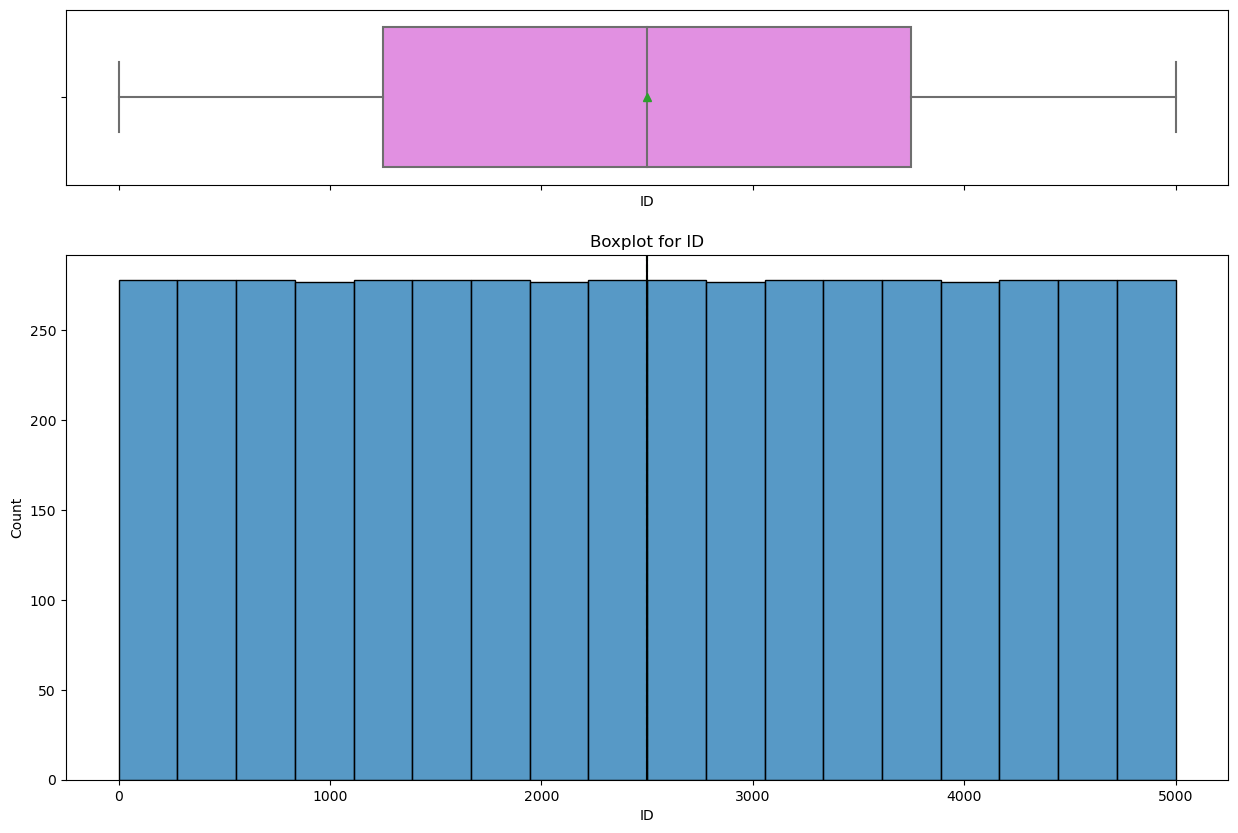

<Figure size 640x480 with 0 Axes>

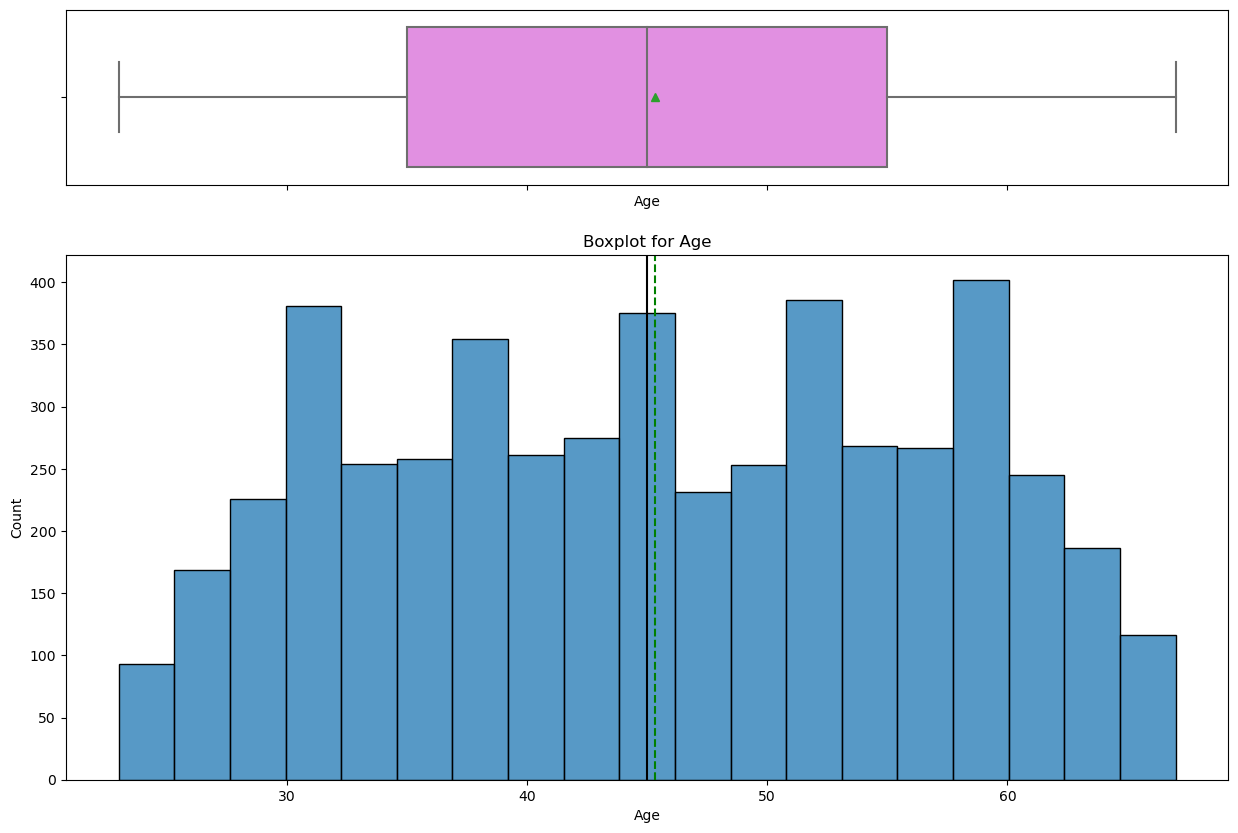

<Figure size 640x480 with 0 Axes>

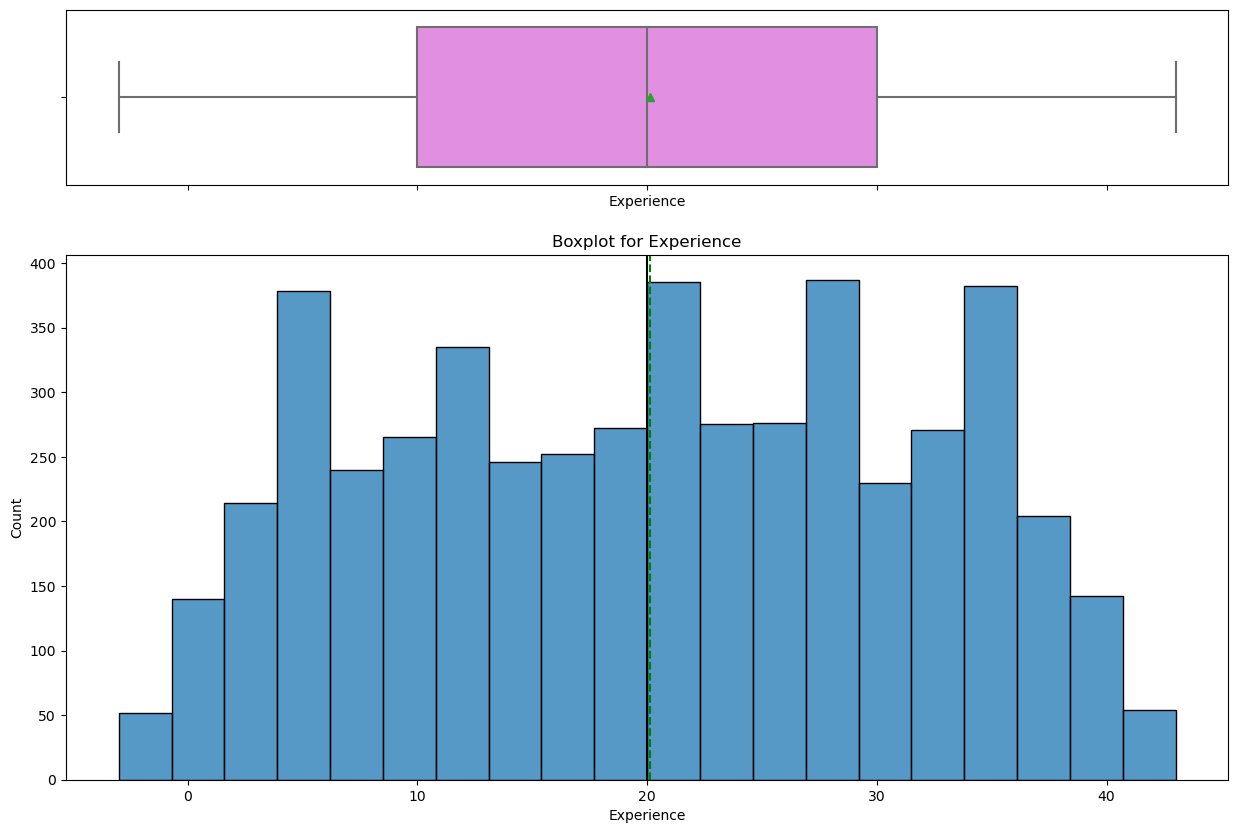

<Figure size 640x480 with 0 Axes>

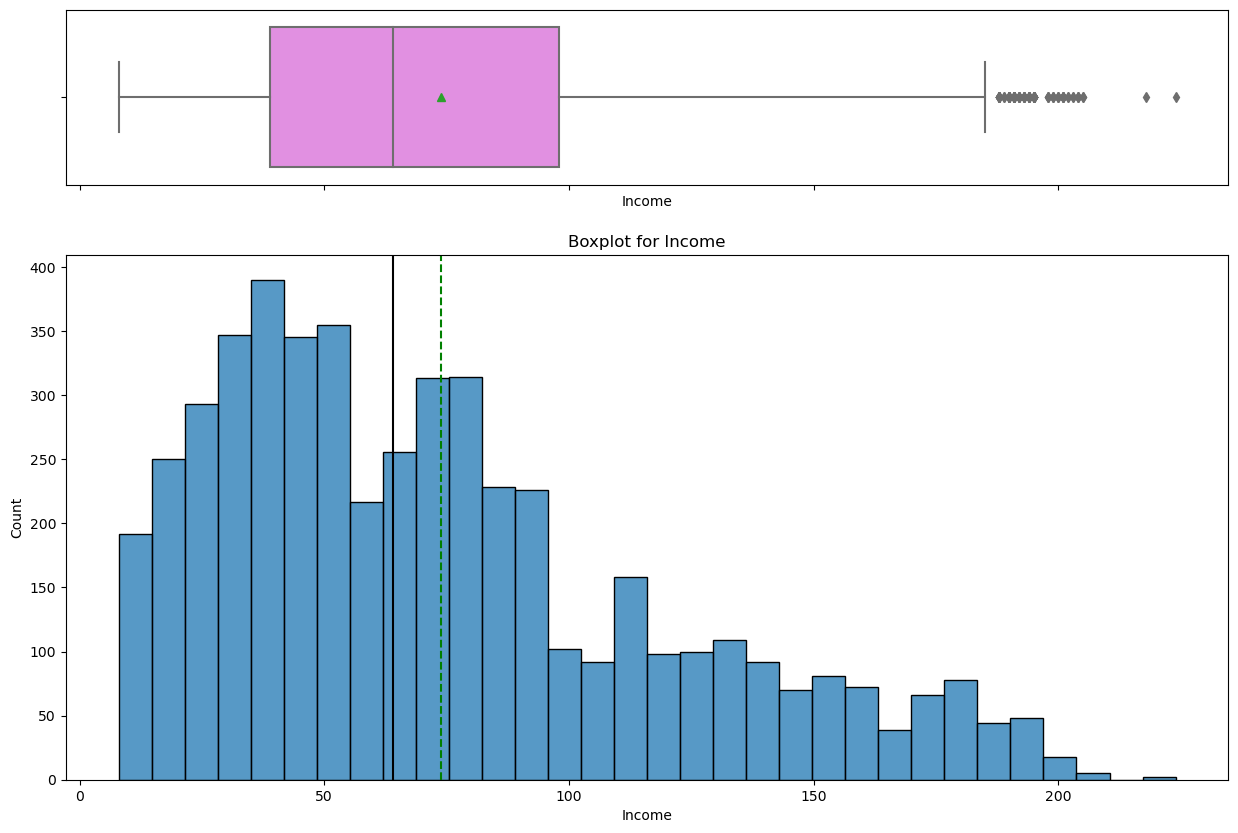

<Figure size 640x480 with 0 Axes>

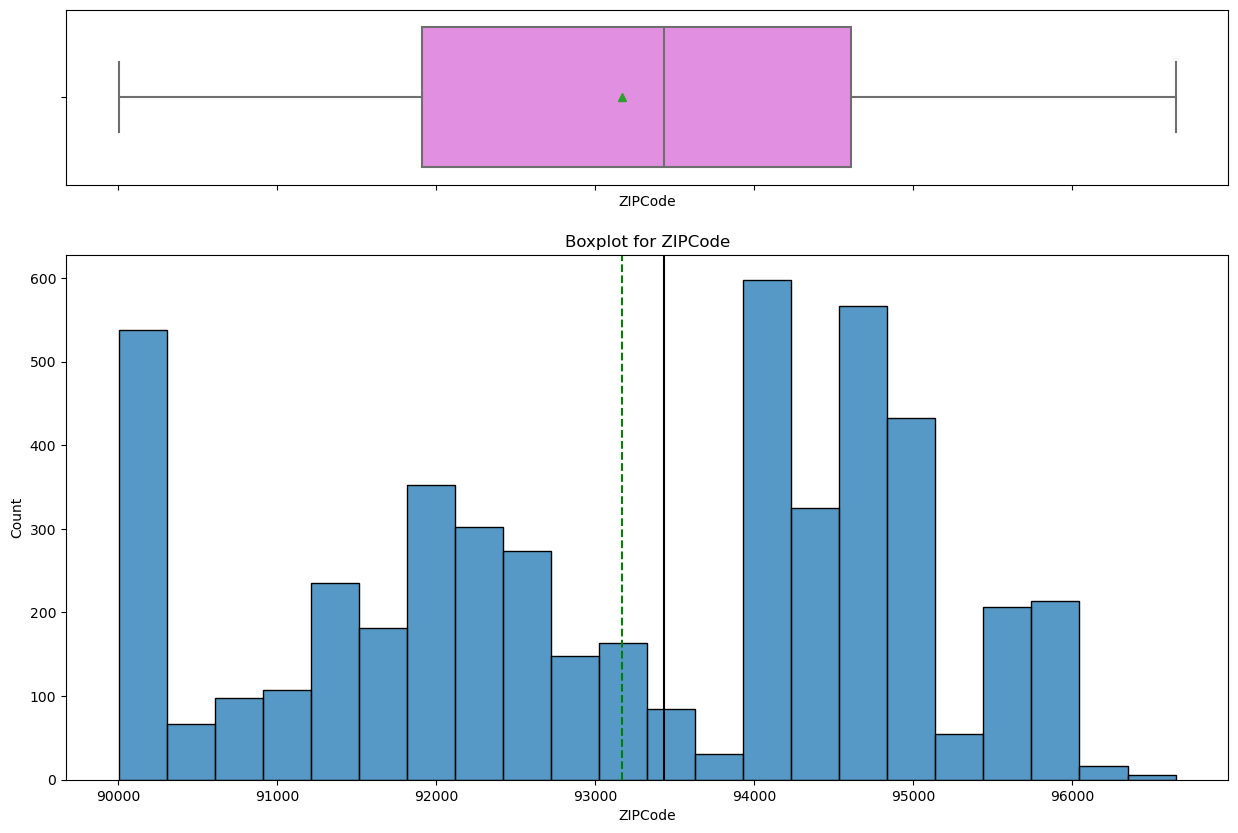

<Figure size 640x480 with 0 Axes>

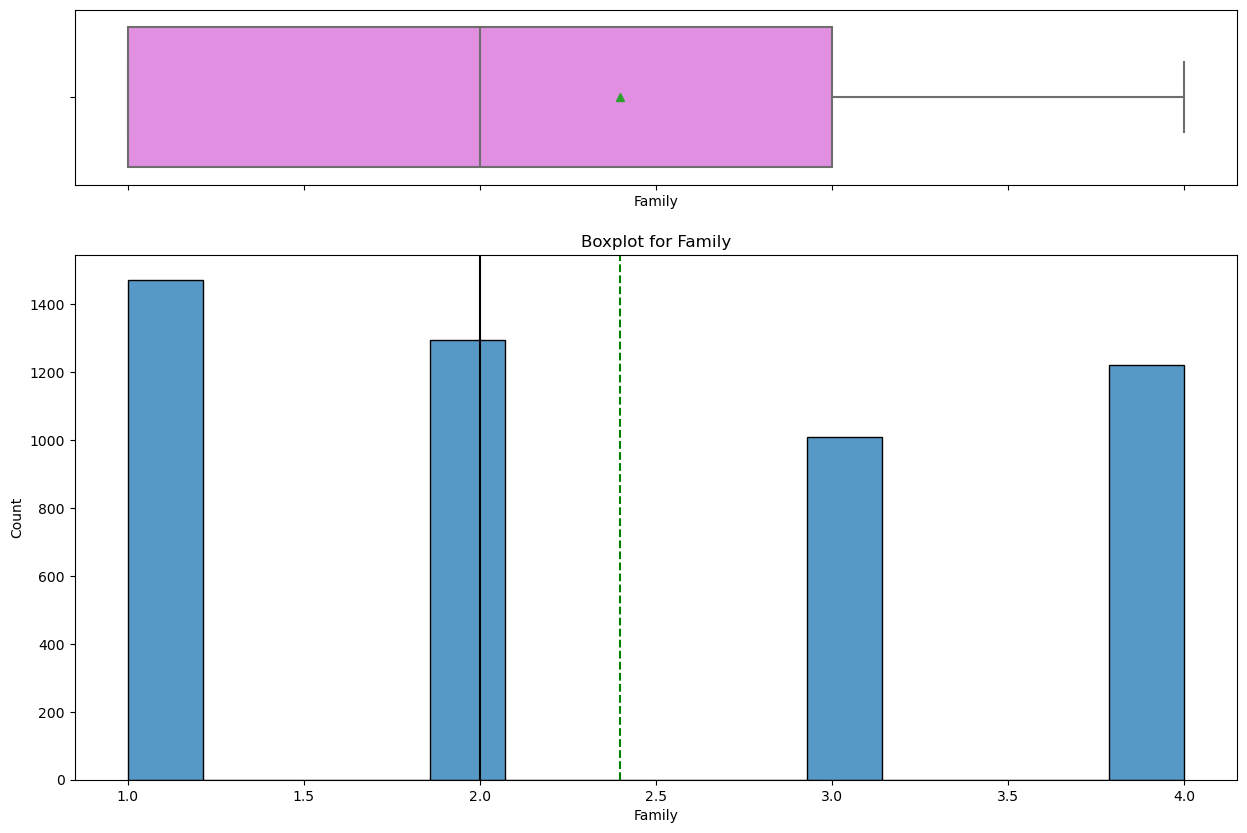

<Figure size 640x480 with 0 Axes>

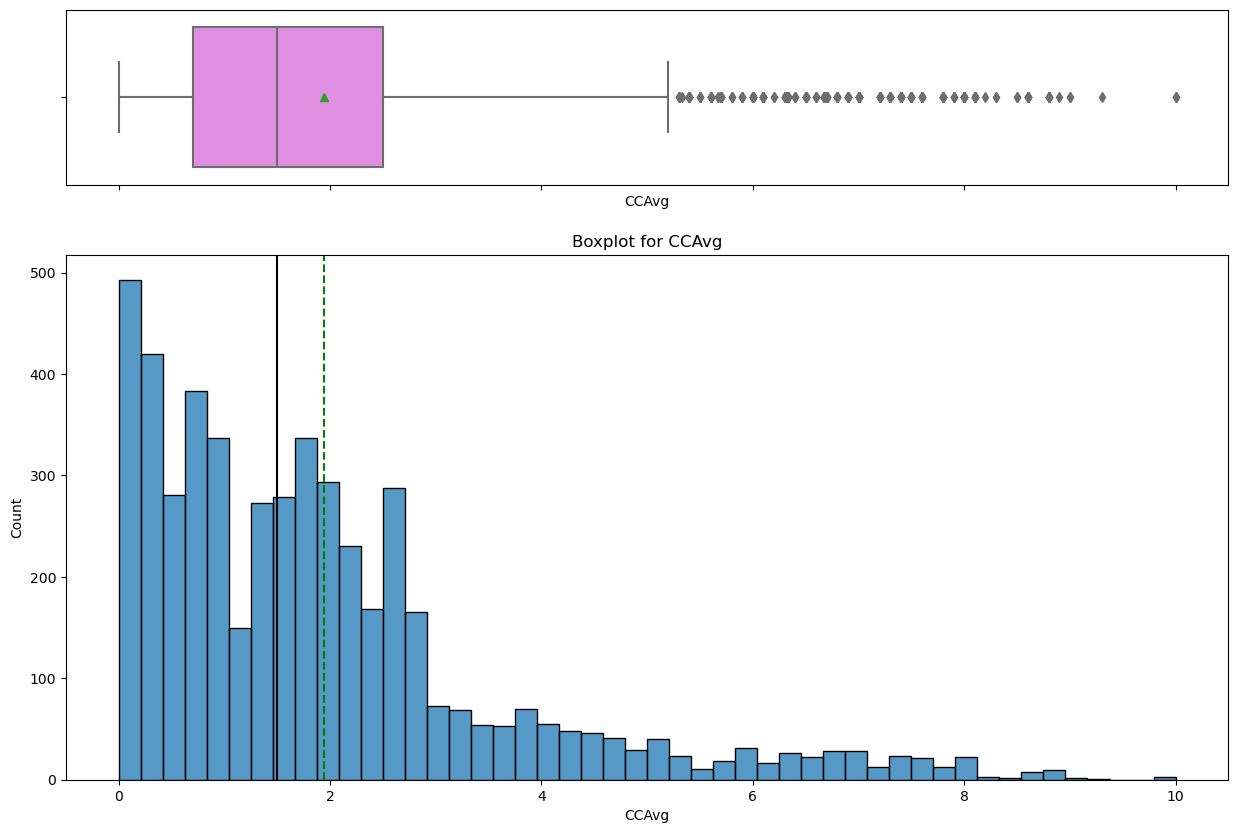

<Figure size 640x480 with 0 Axes>

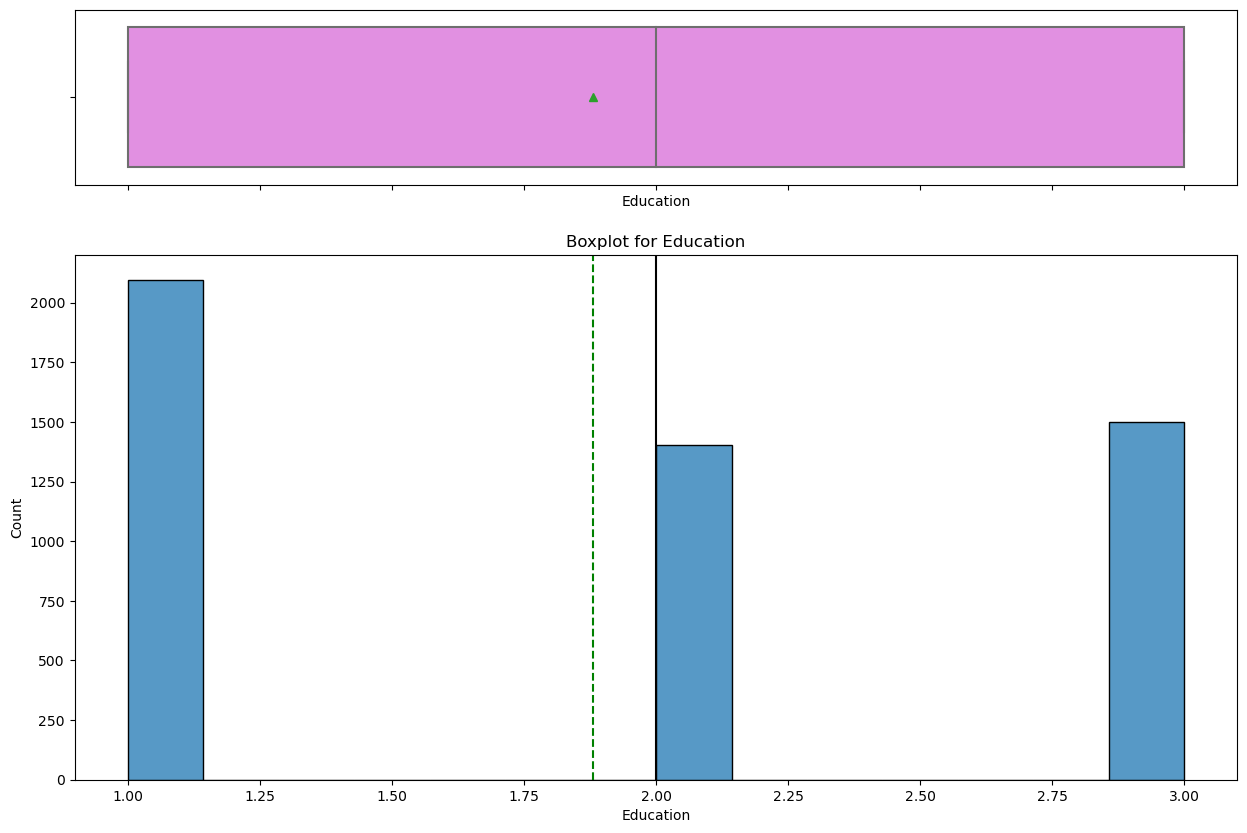

<Figure size 640x480 with 0 Axes>

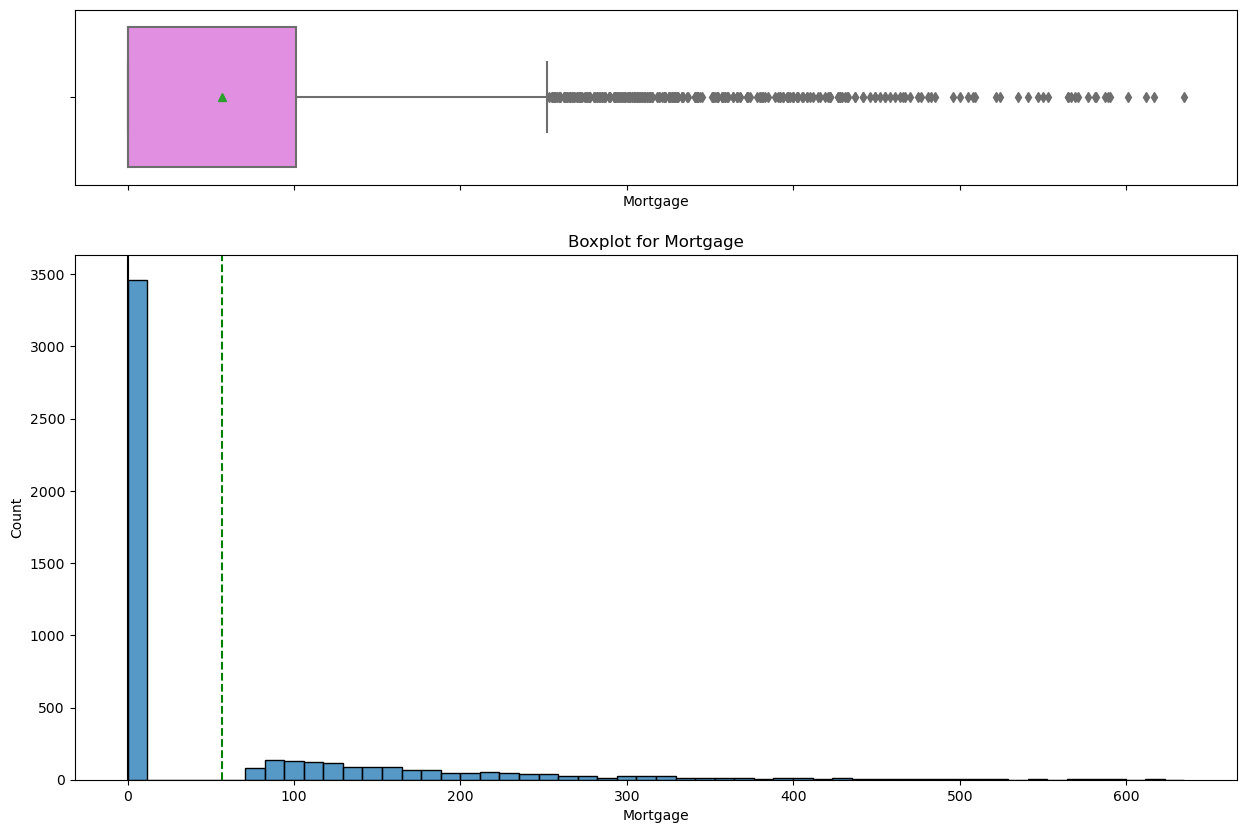

<Figure size 640x480 with 0 Axes>

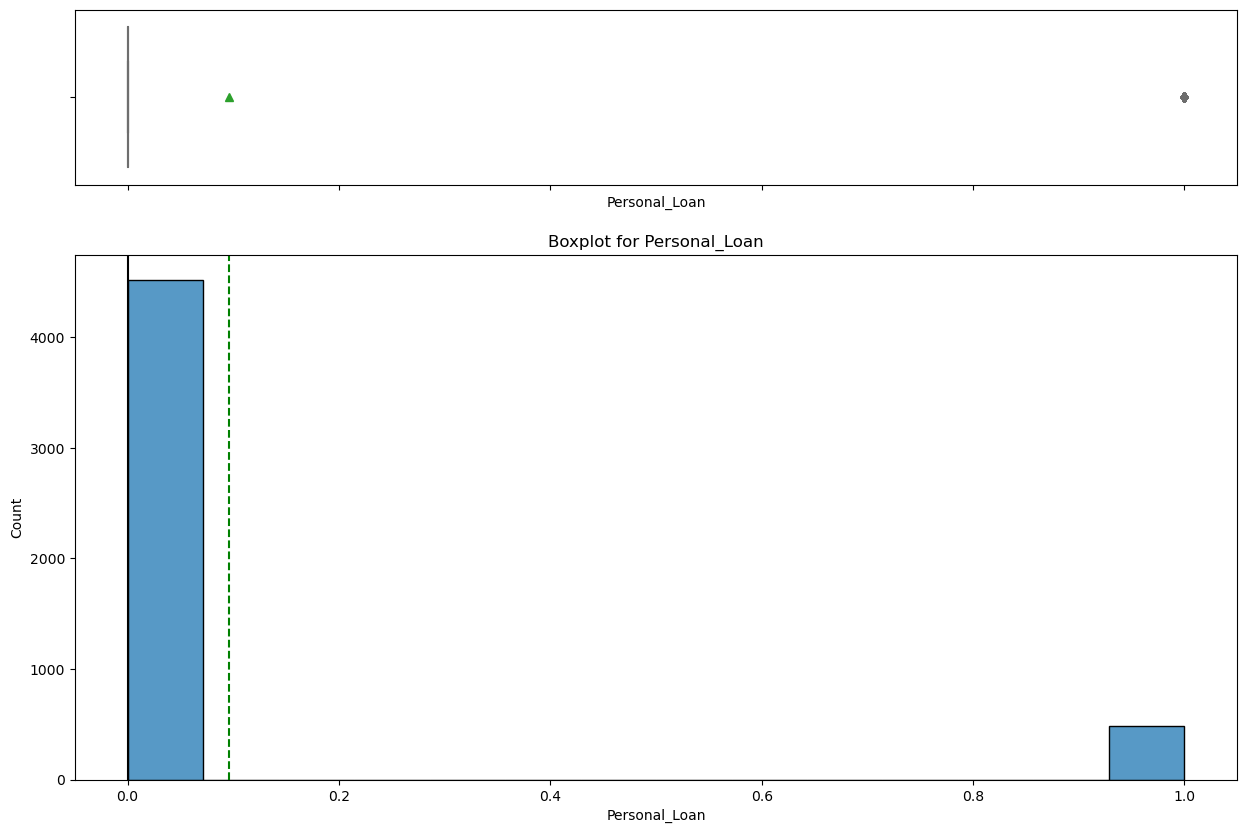

<Figure size 640x480 with 0 Axes>

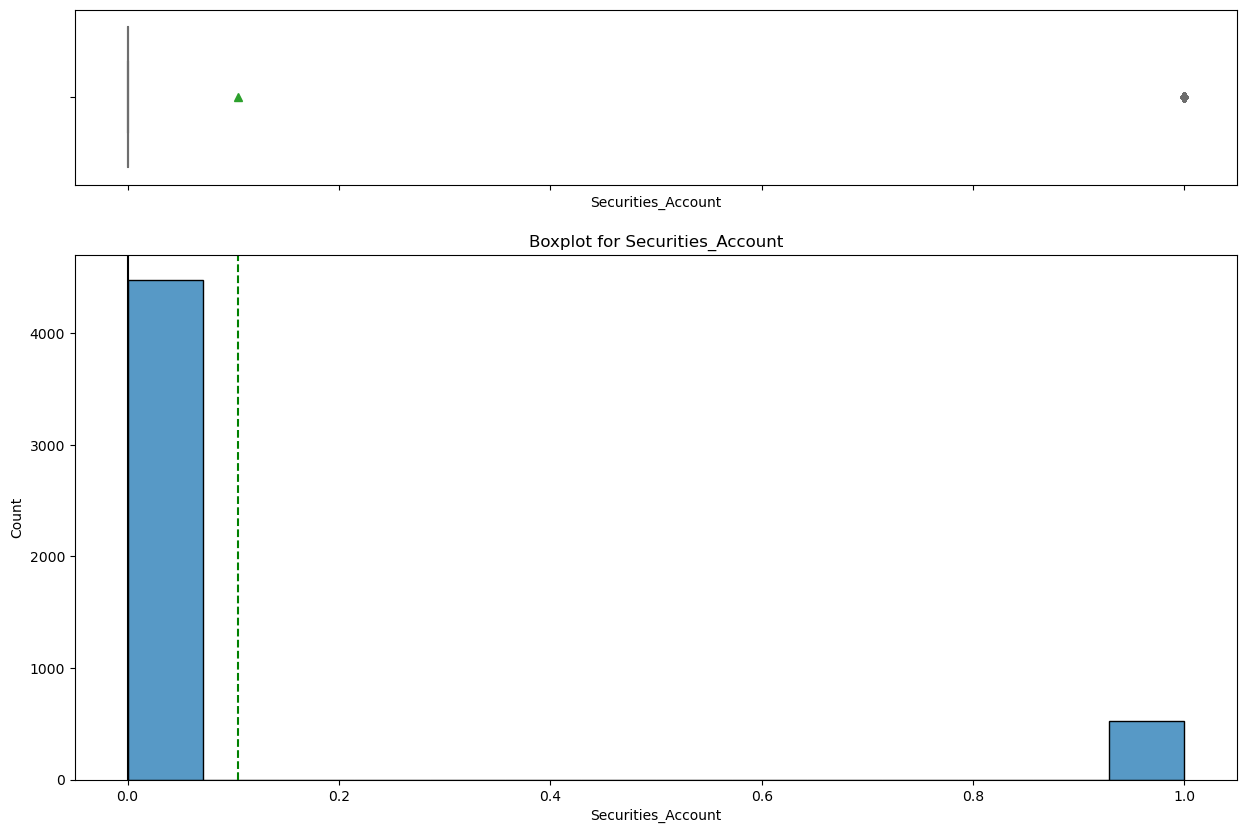

<Figure size 640x480 with 0 Axes>

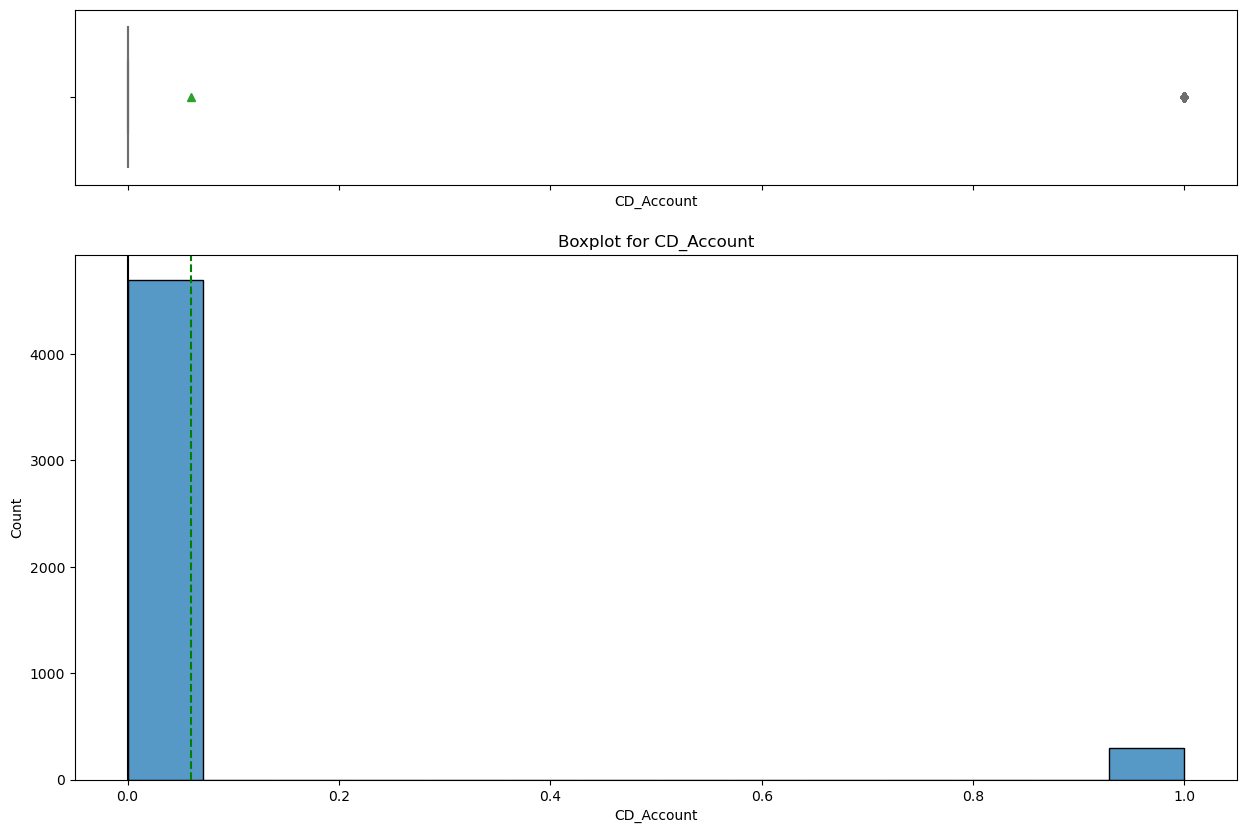

<Figure size 640x480 with 0 Axes>

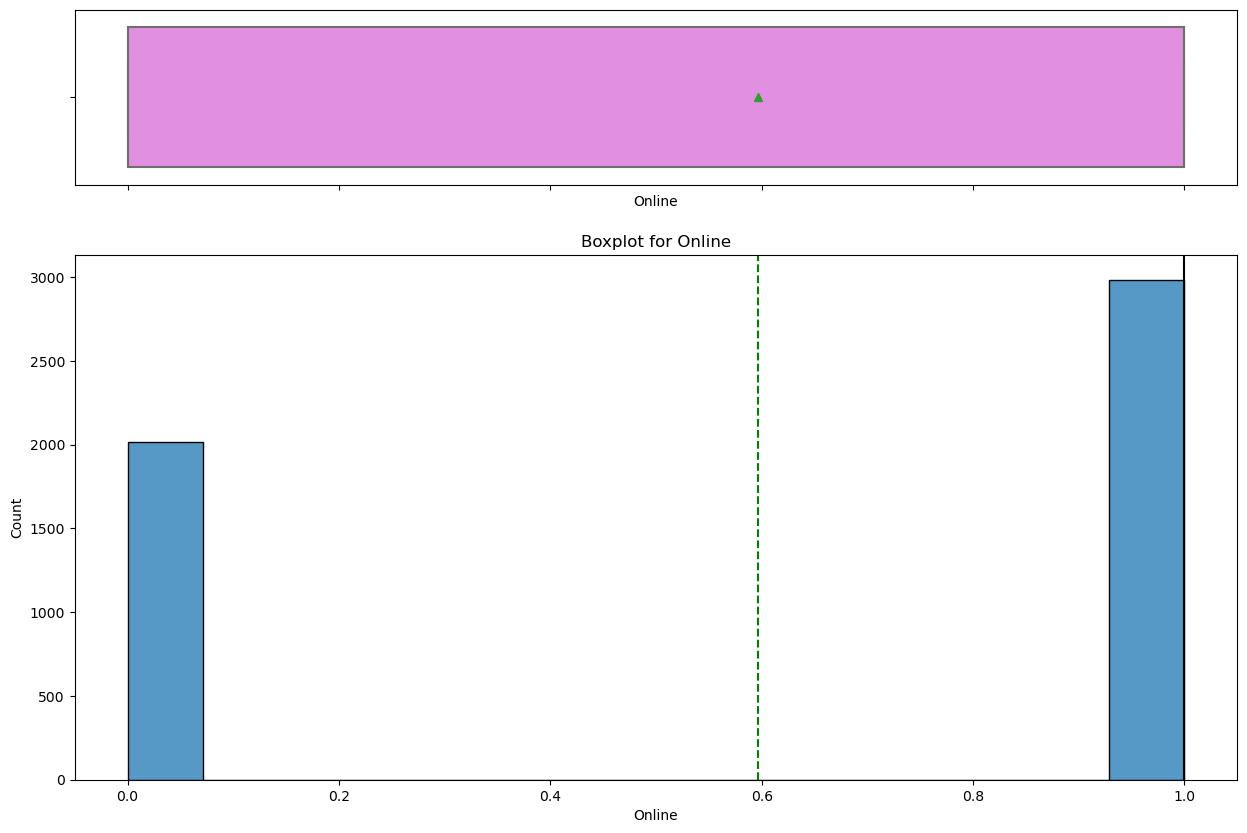

<Figure size 640x480 with 0 Axes>

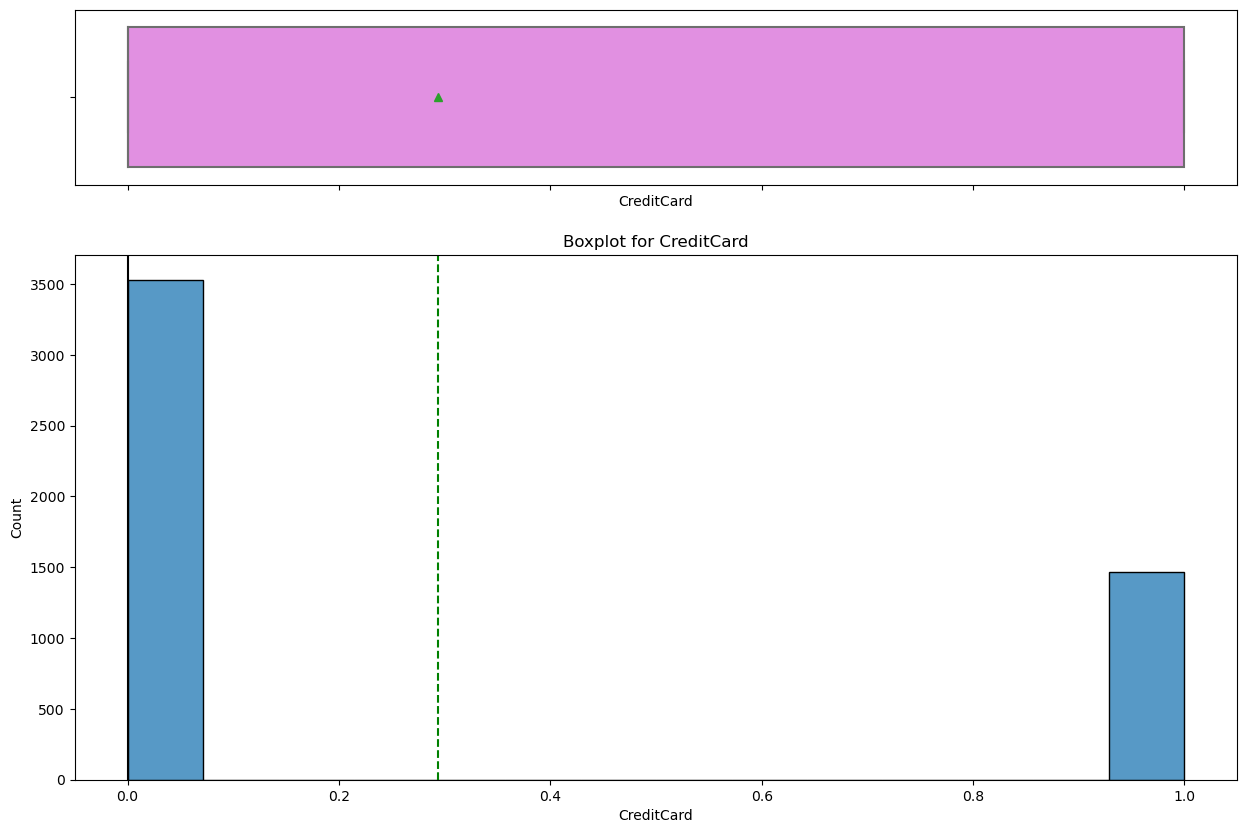

In [16]:
## Univariate analysis

# Create a boxplot for each column in a for loop
for column in CustData_main.columns:
    plt.figure()  # Create a new figure for each boxplot
    histogram_boxplot(CustData_main,column)
    plt.title(f'Boxplot for {column}')



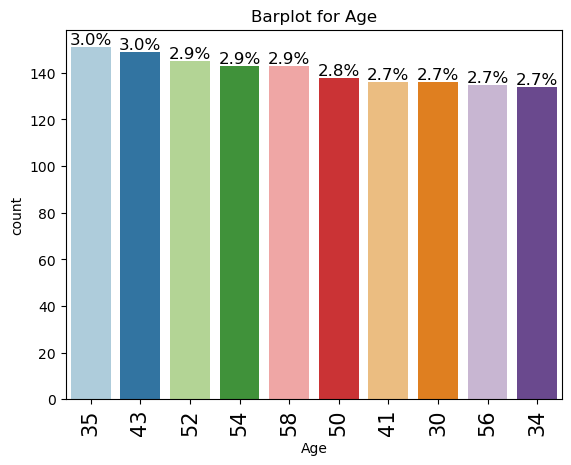

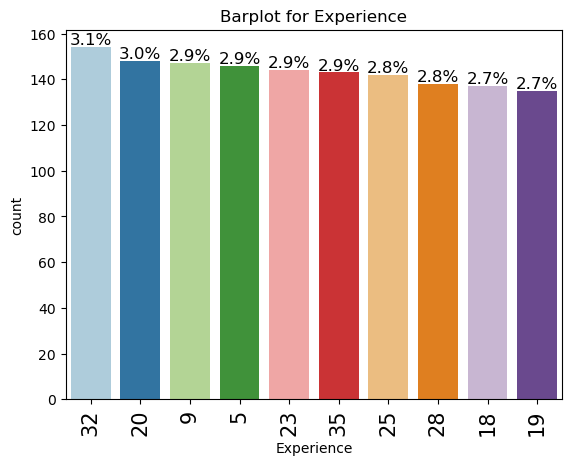

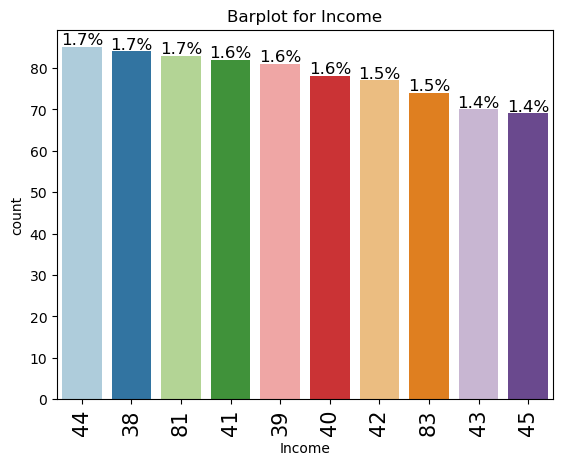

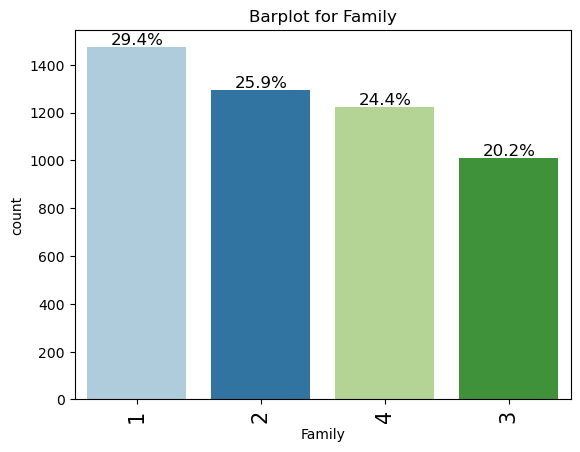

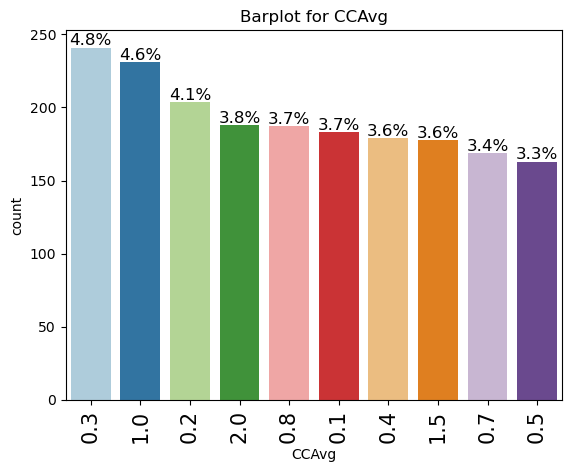

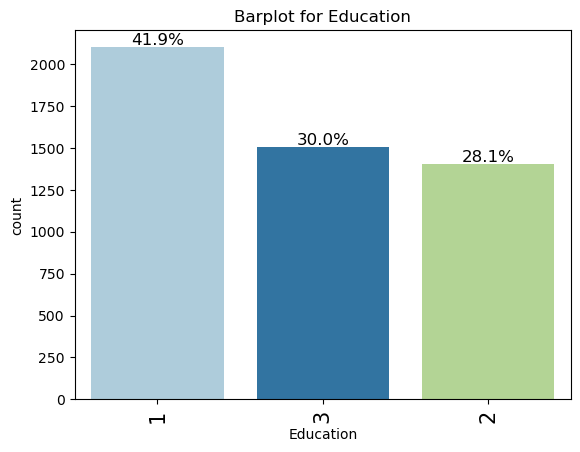

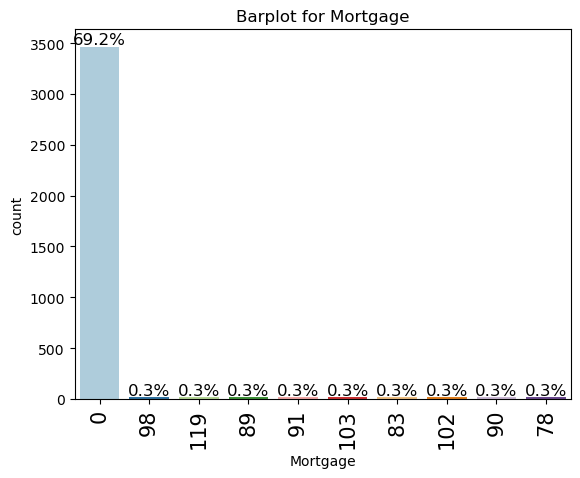

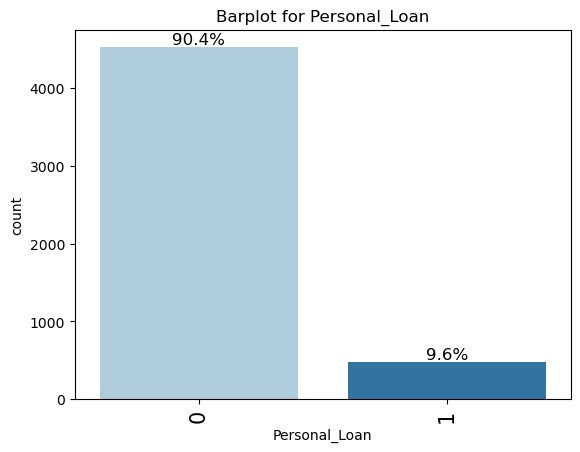

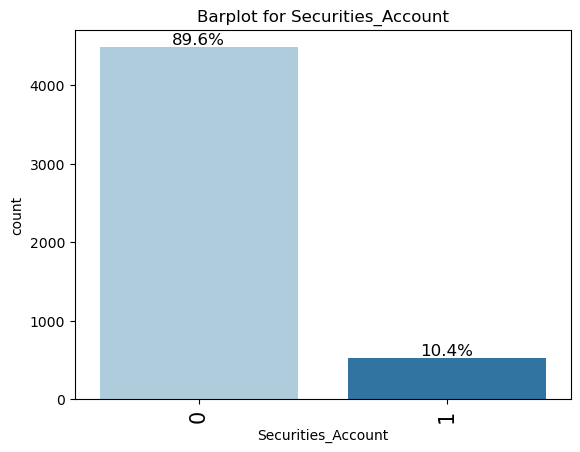

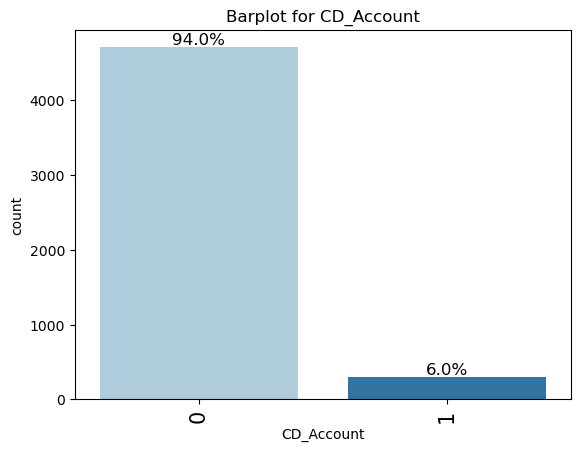

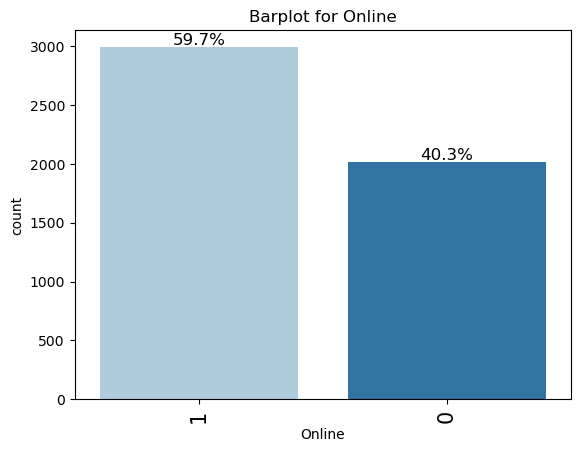

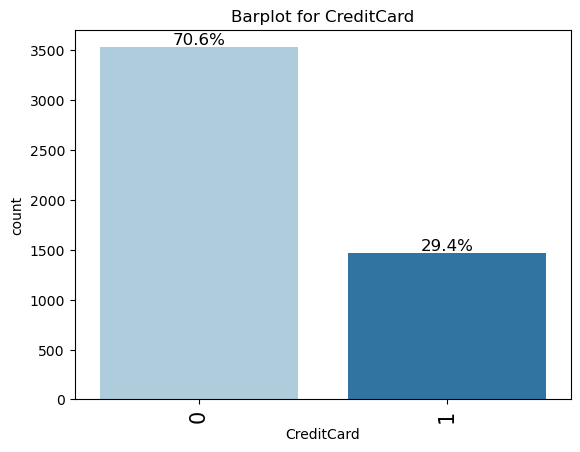

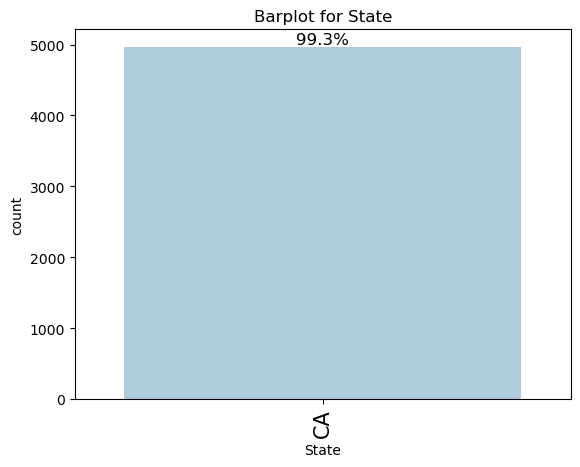

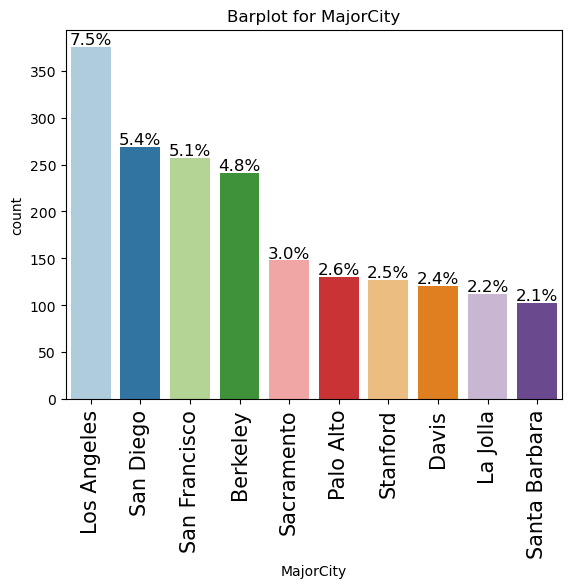

In [17]:
for column in CustData.columns:
    plt.figure()  # Create a new figure for each boxplot
    plt.title(f'Barplot for {column}')
    labeled_barplot(CustData, column, perc=True, n=10)


### Summary of UNIVARIATE EDA:

Univariate:
- Median age of people = 45
- Median exp = 20 yrs
- Median income is ~65, Mean = ~75. There are outliers in the income. Data is right-skewed. Outliers will not be treated.
- Family is right skewed. Median Family size is 2. From the bargraph: THERE IS EQUAL DISTRIBUTION FOR ALL AGES. about 25% each
- Avg on CCAgvg is 1.75-2. There are outliers. Outliers will not be treated.
- Education: Median Education is 2 (Grad). 41% is Undergrad.
- Mortgage: Right skewed. Median is 0. There are outliers but will not be treated. << Need to analyse more
- Personal Loan: Median is 0. Around < 500 people have taken loan. ie around < 10% of the people. Per Bargraph: 90% is 0.
- Securities Account: Median is 0. < 10% of the people have securities account. Per Bargraph: 90% is 0.
- CD_Account: Median is 0. < 250  people have it. ie, < 5%. Per Bargraph: 94% is 0.
- Online: Median is 1. Per Bargraph: 60% is online.
- Credit Card: Median is 0. Per Bargraph: 70% have no CC.
- State: 99% CA
- City: 7.5% is LA

### BIVARIATE EDA

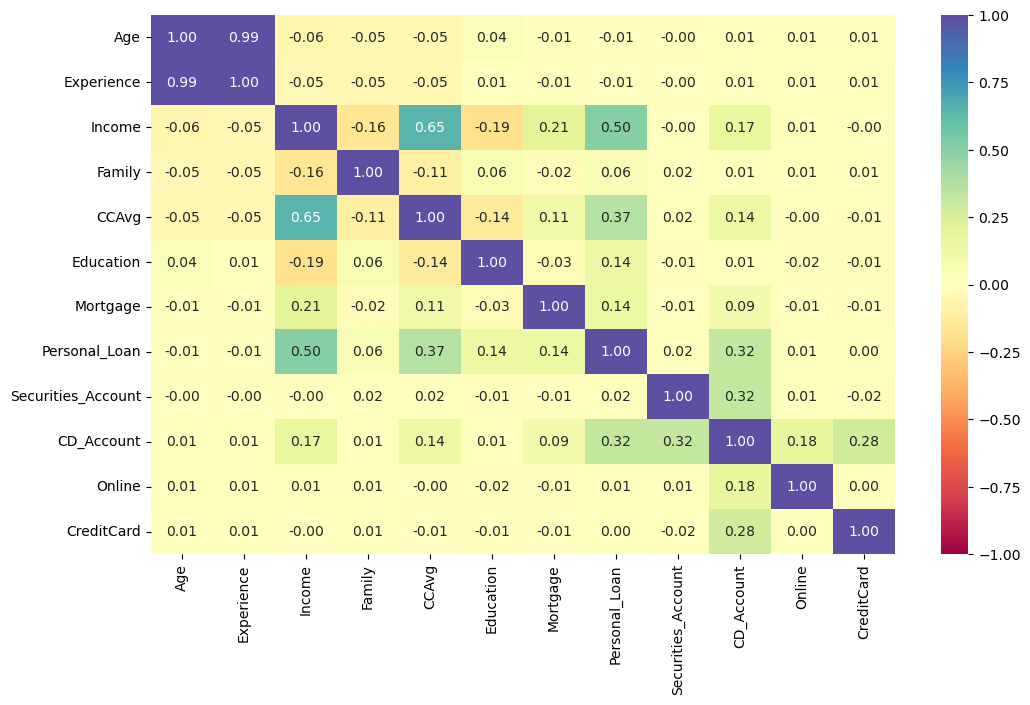

In [18]:
cols_list = CustData.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(12, 7))
sns.heatmap(
    #Cust_Data[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
    CustData[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

In [19]:
CustData.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,State,MajorCity
0,25,1,49,4,1.60000,1,0,0,1,0,0,0,CA,Pasadena
1,45,19,34,3,1.50000,1,0,0,1,0,0,0,CA,Los Angeles
2,39,15,11,1,1.00000,1,0,0,0,0,0,0,CA,Berkeley
3,35,9,100,1,2.70000,2,0,0,0,0,0,0,CA,San Francisco
4,35,8,45,4,1.00000,2,0,0,0,0,0,1,CA,Northridge


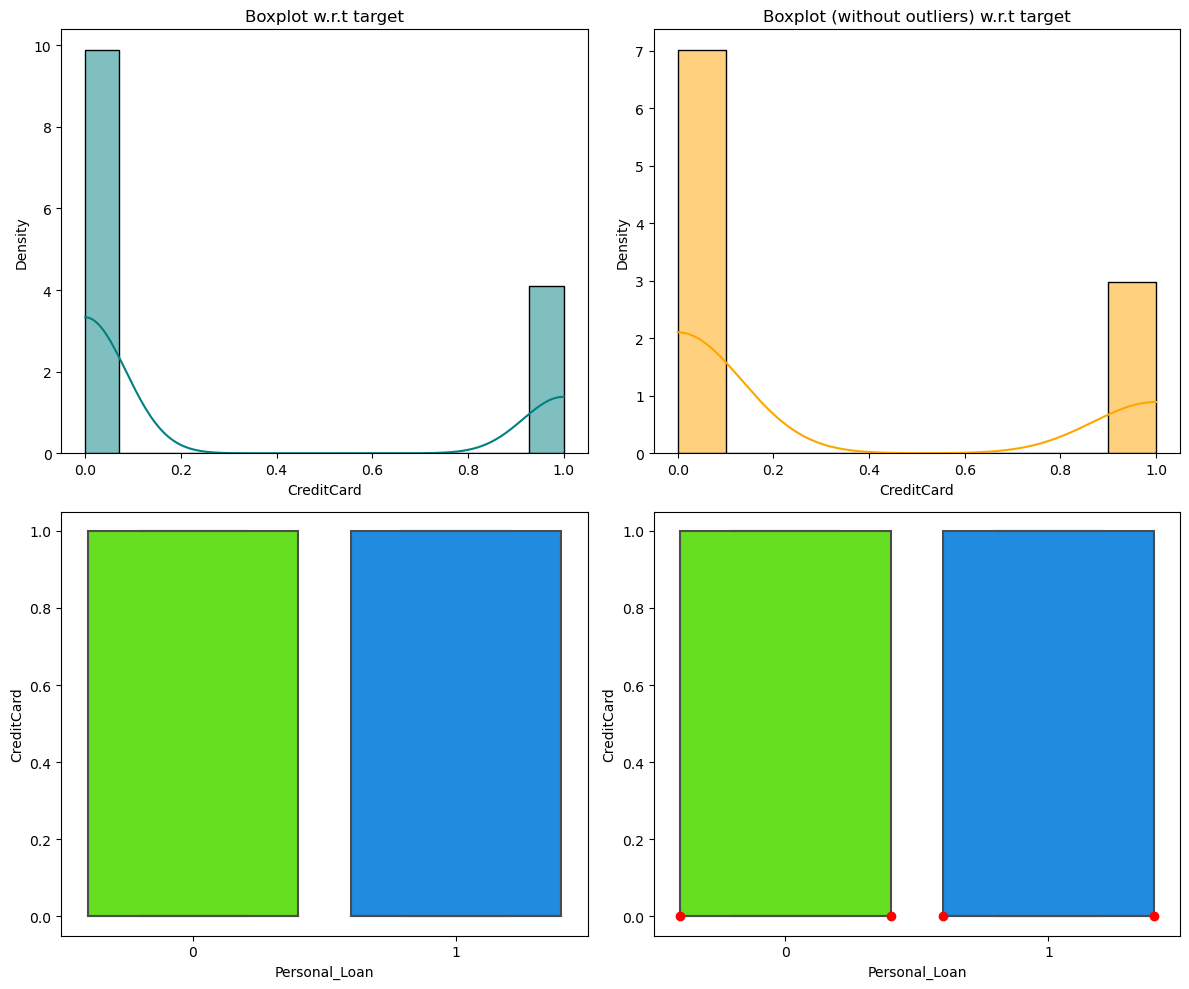

In [20]:
distribution_plot_wrt_target(CustData, "CreditCard", "Personal_Loan")

Personal_Loan     0    1   All
MajorCity                     
All            4489  477  4966
Los Angeles     337   38   375
Berkeley        214   27   241
San Diego       248   21   269
San Francisco   238   19   257
...             ...  ...   ...
Edwards           5    0     5
North Hills       3    0     3
Bodega Bay        6    0     6
National City     7    0     7
Agoura Hills      6    0     6

[245 rows x 3 columns]
------------------------------------------------------------------------------------------------------------------------


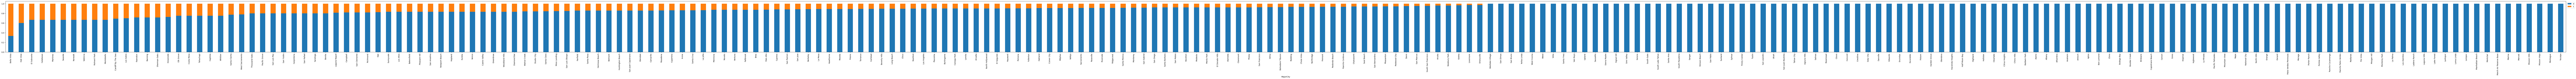

In [21]:
stacked_barplot(CustData, "MajorCity", "Personal_Loan")

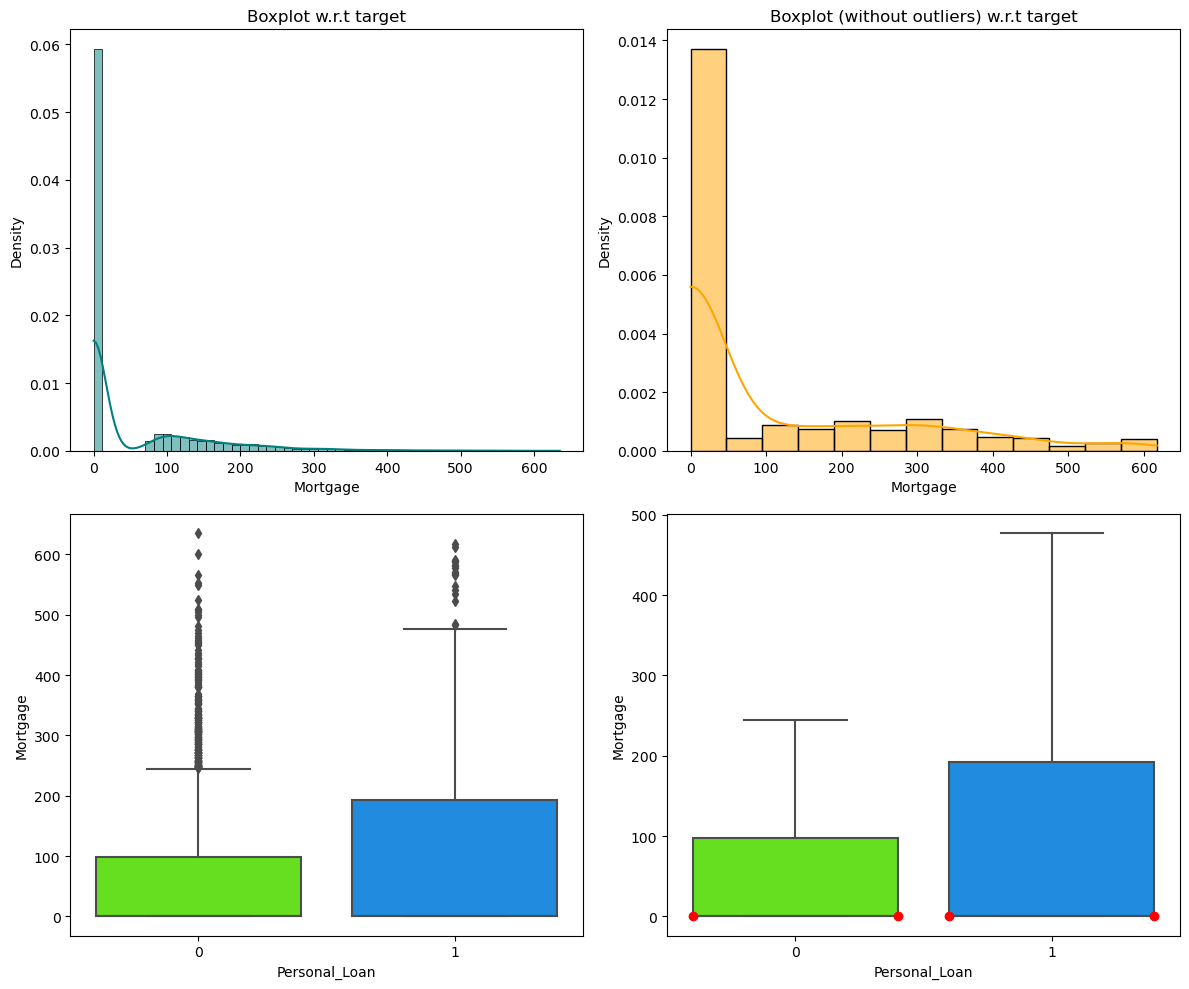

In [22]:
distribution_plot_wrt_target(CustData, "Mortgage", "Personal_Loan")

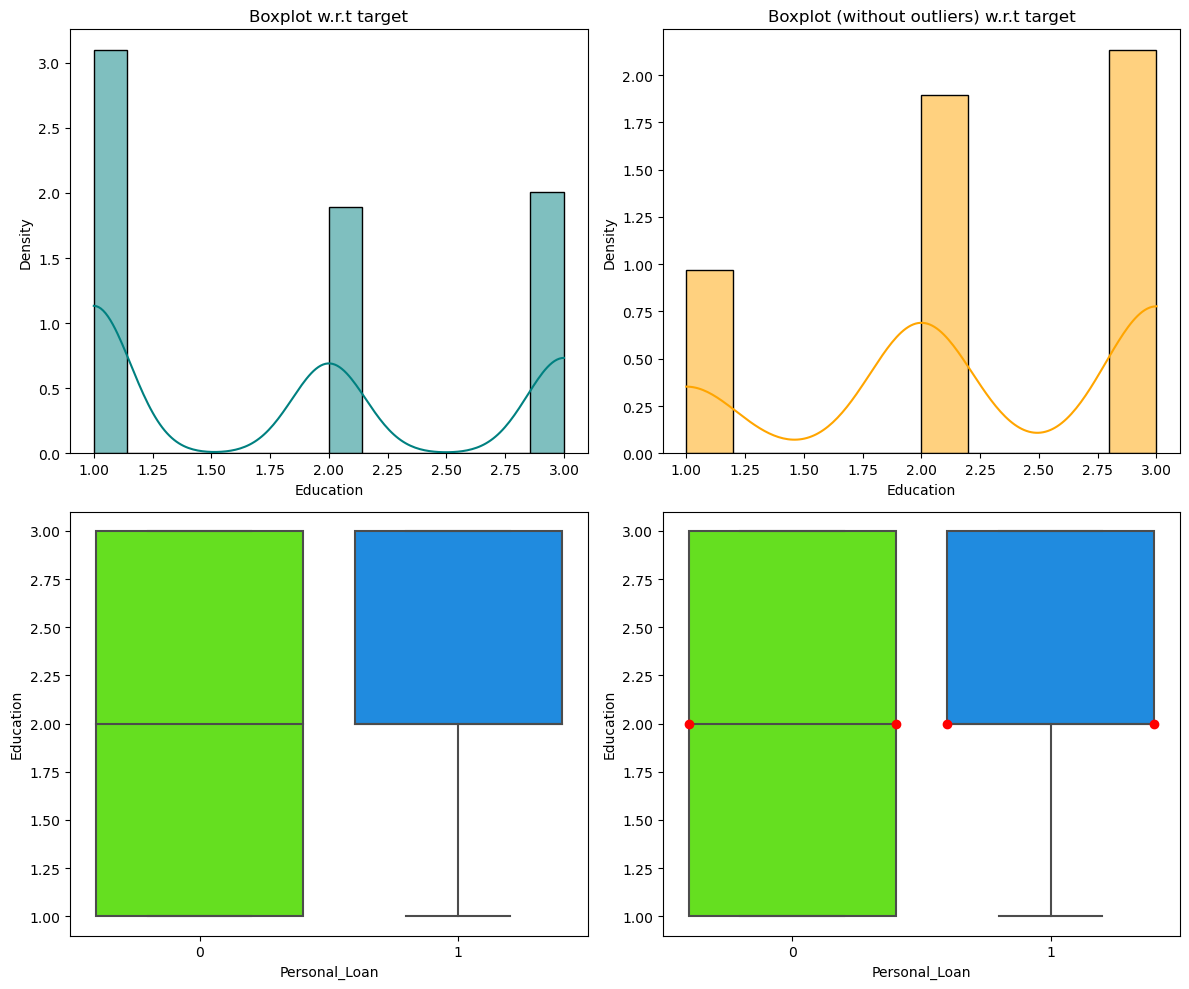

In [23]:
distribution_plot_wrt_target(CustData, "Education", "Personal_Loan")

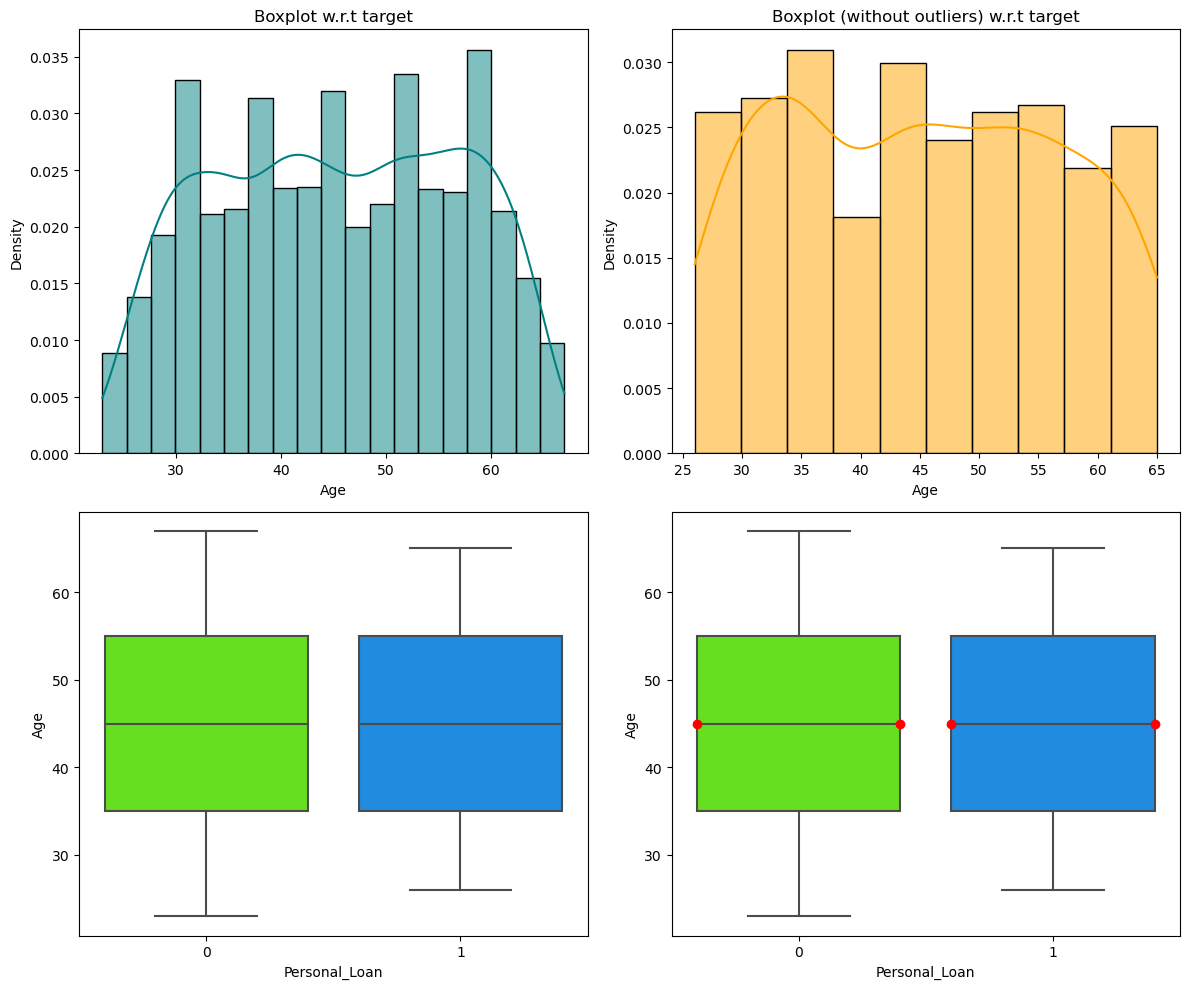

In [24]:
distribution_plot_wrt_target(CustData, "Age", "Personal_Loan")

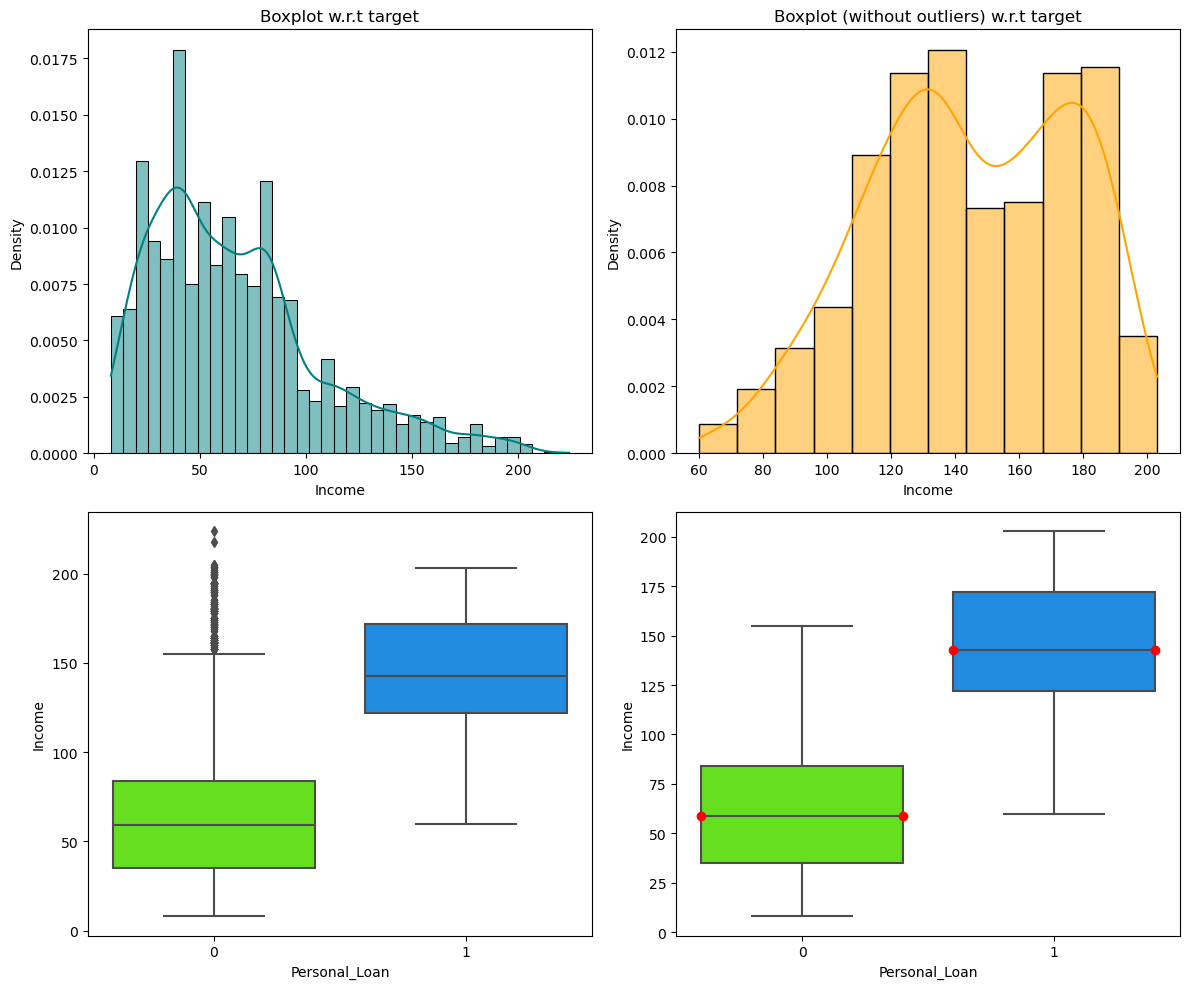

In [25]:
distribution_plot_wrt_target(CustData, "Income", "Personal_Loan")

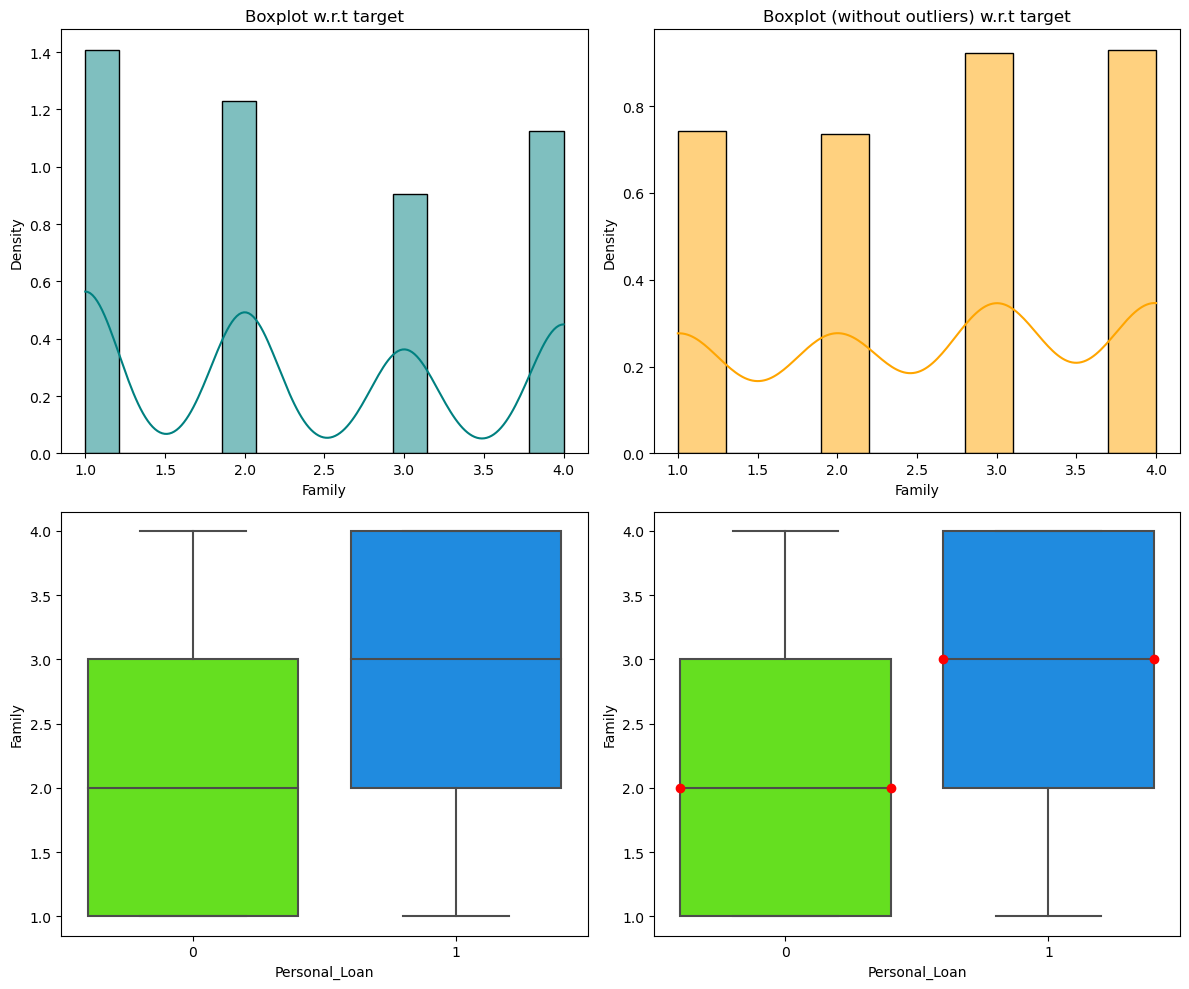

In [26]:

distribution_plot_wrt_target(CustData, "Family", "Personal_Loan")

### Summary of BIVARIATE EDA:
- Among the higher correlations, the correlation between CCAvg and Income are strongest. Then the target variable of Personal_Loan and Income have the NEXT Highest correlation. Indicates higher income has a slightly higher tendency for credit.

- Personal loans are taken by people with median 3 family members and 75% of people having 4 family members and below
- Personal loans are taken by people with more income (median around 140 per month) and in 75% range of 160-170 and below.
- Personal loans are taken by 75% of people having CCavg that is slightly > 5 (median 3.75) and below.
- Personal loans are taken by people with education 2 and 3
- Personal loans are taken by 75% of people having mortage =200 and below (median = 0)
- 65% of customers in BellaVista have personal loans . 40% of customers in Oak View have personal loans.
- Based on correlation between CCAvg, Income and Personal Loan, 192 customers are a 50% target








In [27]:
CustData.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,State,MajorCity
0,25,1,49,4,1.60000,1,0,0,1,0,0,0,CA,Pasadena
1,45,19,34,3,1.50000,1,0,0,1,0,0,0,CA,Los Angeles
2,39,15,11,1,1.00000,1,0,0,0,0,0,0,CA,Berkeley
3,35,9,100,1,2.70000,2,0,0,0,0,0,0,CA,San Francisco
4,35,8,45,4,1.00000,2,0,0,0,0,0,1,CA,Northridge


In [28]:
CustData.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,5000.00000,45.33840,11.46317,23.00000,35.00000,45.00000,55.00000,67.00000
Experience,5000.00000,20.10460,11.46795,-3.00000,10.00000,20.00000,30.00000,43.00000
Income,5000.00000,73.77420,46.03373,8.00000,39.00000,64.00000,98.00000,224.00000
Family,5000.00000,2.39640,1.14766,1.00000,1.00000,2.00000,3.00000,4.00000
CCAvg,5000.00000,1.93794,1.74766,0.00000,0.70000,1.50000,2.50000,10.00000
Education,5000.00000,1.88100,0.83987,1.00000,1.00000,2.00000,3.00000,3.00000
Mortgage,5000.00000,56.49880,101.71380,0.00000,0.00000,0.00000,101.00000,635.00000
Personal_Loan,5000.00000,0.09600,0.29462,0.00000,0.00000,0.00000,0.00000,1.00000
Securities_Account,5000.00000,0.10440,0.30581,0.00000,0.00000,0.00000,0.00000,1.00000
CD_Account,5000.00000,0.06040,0.23825,0.00000,0.00000,0.00000,0.00000,1.00000


### Based on correlation between CCAvg, Income and Personal Loan, 192 new customers are a 50% target / 50% likely to take a new loan

- Likelihood highest in LA, San Diego, Santa Barbara, SanFrancisco/Livermore
- Customers who are 'CCAvg' >= 3.75 & No 'Personal_Loan' & 'Income' >= 137.5 , there are 192 customers who are 50% likely to take a personal loan

In [29]:
filtered_df = CustData[
                (CustData['CCAvg'] >= 3.75) & 
                 (CustData['Personal_Loan'] == 0) & 
                 (CustData['Income'] >= 137.5) ]

# Based on correlation between CCAvg, Income and Personal Loan, 192 customers are a 50% target

In [30]:
filtered_df.shape

(192, 14)

In [31]:
filtered_df.head(5)

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,State,MajorCity
24,36,11,152,2,3.90000,1,159,0,0,0,0,1,CA,Arcata
55,41,17,139,2,8.00000,1,0,0,0,0,1,0,CA,Los Altos
59,31,5,188,2,4.50000,1,455,0,0,0,0,0,CA,Newbury Park
172,38,13,171,2,7.80000,1,0,0,0,0,1,0,None,None
194,53,29,144,2,6.80000,1,0,0,0,0,1,0,CA,Irvine


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


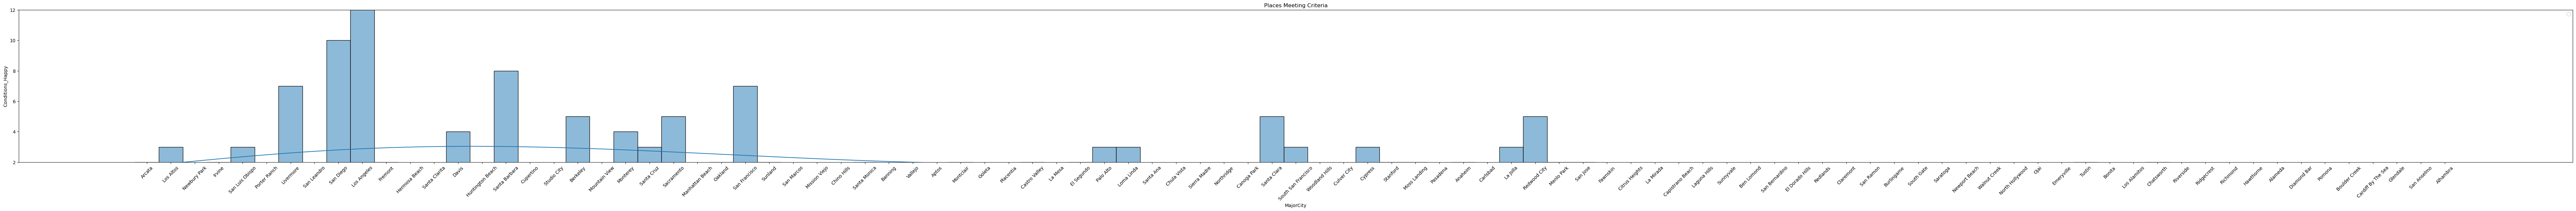

In [32]:
# Create a  plot
#plt.histplot(filtered_df['MajorCity'], filtered_df.value_counts(), color='red', label='Filtered Places')
plt.figure(figsize=(100, 6))
sns.histplot(
        data=filtered_df, x=filtered_df['MajorCity'], kde=True, bins='auto' )

plt.xlabel('MajorCity')
plt.ylabel('Conditions_Happy')
plt.ylim(2, 12) 
plt.xticks(rotation=45)
plt.title('Places Meeting Criteria')
plt.legend()
plt.show()

Likelihood highest in LA, San Diego, Santa Barbara, SanFrancisco/Livermore

## Data Preprocessing

* Missing value treatment
* Feature engineering (if needed)
* Outlier detection and treatment (if needed)
* Preparing data for modeling
* Any other preprocessing steps (if needed)

#### Observations
- No missing values. 
- No outlier treatment since decision trees are resistant.
- There are some negative/minus experience values which are not valid  and might affect calculations. So, we will to Set them to 0.
- There are some 'None' entries for Pincode after conversion from ZIPCode to State/City using the converter. Ignore them.
- One hot encoding can be done for the City (State is CA always in the database).


***Outlier Detection***

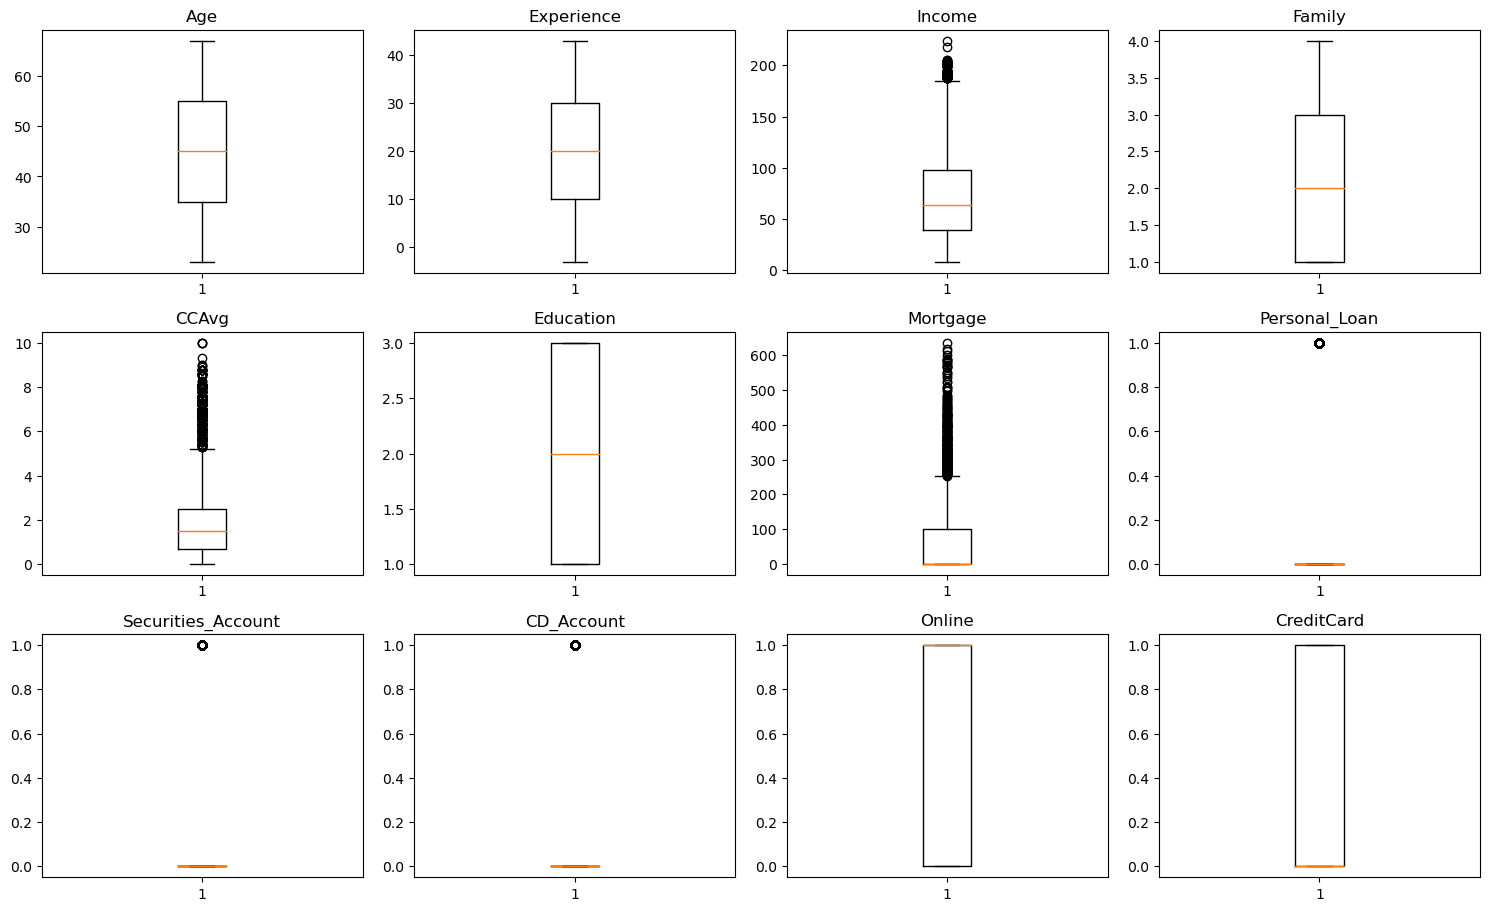

In [33]:
#Outlier detection

# outlier detection using boxplot
numeric_columns = CustData.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(CustData[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

In [34]:
# Missing values of Pincode.. some None entries in State and MajorCity. Ignore.
#CustData_main['ZIPCode']).sum()
count_state_none = (CustData['State'] == 'None').sum()
count_state_none

0

***Missing/Incorrect Value Treatment***

In [35]:
# Missing value treatmeent
# checking if experience <0 . Not a valid value for Experience.
CustData[CustData["Experience"] < 0]["Experience"].unique()
CustData['Education'] = CustData['Education'].abs()
#CustData["Education"].replace(1, "Undergraduate", inplace=True)
#CustData["Education"].replace(2, "Graduate", inplace=True)
#CustData["Education"].replace(3, "Professional", inplace=True)
#CustData['Experience'] = CustData['Experience'].clip(lower=0)
CustData
CustData['Experience'].head()



0     1
1    19
2    15
3     9
4     8
Name: Experience, dtype: int64

***Convert to categories  the columns that are categories***


In [36]:
# Convert to categories  the columns that are categories
## Decision tree can handle ordinal relationships also in categorical variables

categ_cols = [
    "Education",
    "Personal_Loan",
    "Securities_Account",
    "CD_Account",
    "Online",
    "CreditCard",
    "MajorCity"
]
CustData[categ_cols] = CustData[categ_cols].astype("category")    # Complete the code to convert the cat_cols to category


In [37]:
CustData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   int64   
 3   Family              5000 non-null   int64   
 4   CCAvg               5000 non-null   float64 
 5   Education           5000 non-null   category
 6   Mortgage            5000 non-null   int64   
 7   Personal_Loan       5000 non-null   category
 8   Securities_Account  5000 non-null   category
 9   CD_Account          5000 non-null   category
 10  Online              5000 non-null   category
 11  CreditCard          5000 non-null   category
 12  State               4966 non-null   object  
 13  MajorCity           4966 non-null   category
dtypes: category(7), float64(1), int64(5), object(1)
memory usage: 323.4+ KB


In [38]:
#CustData['MajorCity'] = pd.to_numeric(CustData['MajorCity'], errors='coerce')
# Drop state name as it is not a differentiating factor as all data is from 
CustData = CustData.drop(columns='State')

In [39]:
#convert MajorCity to category, if not already done
for feature in CustData.columns: # Loop through all columns in the dataframe
    if CustData[feature].dtype == 'object': # Only apply for columns with categorical strings
        CustData[feature] = pd.Categorical(CustData[feature])
CustData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 5000 non-null   int64   
 1   Experience          5000 non-null   int64   
 2   Income              5000 non-null   int64   
 3   Family              5000 non-null   int64   
 4   CCAvg               5000 non-null   float64 
 5   Education           5000 non-null   category
 6   Mortgage            5000 non-null   int64   
 7   Personal_Loan       5000 non-null   category
 8   Securities_Account  5000 non-null   category
 9   CD_Account          5000 non-null   category
 10  Online              5000 non-null   category
 11  CreditCard          5000 non-null   category
 12  MajorCity           4966 non-null   category
dtypes: category(7), float64(1), int64(5)
memory usage: 284.3 KB


In [40]:
print(CustData.MajorCity.value_counts())

MajorCity
Los Angeles      375
San Diego        269
San Francisco    257
Berkeley         241
Sacramento       148
                ... 
Tahoe City         1
Sausalito          1
Stinson Beach      1
Sierra Madre       1
Ladera Ranch       1
Name: count, Length: 244, dtype: int64


#### Preparation of Training and Test sets and Dummies

In [41]:
X = CustData.drop(["Personal_Loan"], axis=1)
Y = CustData["Personal_Loan"]

## Create dummy variables for MajorCity
X = pd.get_dummies(X, columns=["MajorCity"],drop_first=True)

#Model 1 with City and dummies

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1
)
print("### WITH DUMMIES#### ")
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

### WITH DUMMIES#### 
Shape of Training set :  (3500, 254)
Shape of test set :  (1500, 254)
Percentage of classes in training set:
Personal_Loan
0   0.90543
1   0.09457
Name: proportion, dtype: float64
Percentage of classes in test set:
Personal_Loan
0   0.90067
1   0.09933
Name: proportion, dtype: float64


In [42]:
X.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities_Account,CD_Account,Online,CreditCard,MajorCity_Alameda,MajorCity_Alamo,MajorCity_Albany,MajorCity_Alhambra,MajorCity_Anaheim,MajorCity_Antioch,MajorCity_Aptos,MajorCity_Arcadia,MajorCity_Arcata,MajorCity_Bakersfield,MajorCity_Baldwin Park,MajorCity_Banning,MajorCity_Bella Vista,MajorCity_Belmont,MajorCity_Belvedere Tiburon,MajorCity_Ben Lomond,MajorCity_Berkeley,MajorCity_Beverly Hills,MajorCity_Bodega Bay,MajorCity_Bonita,MajorCity_Boulder Creek,MajorCity_Brea,MajorCity_Brisbane,MajorCity_Burlingame,MajorCity_Calabasas,MajorCity_Camarillo,MajorCity_Campbell,MajorCity_Canoga Park,MajorCity_Capistrano Beach,MajorCity_Capitola,MajorCity_Cardiff By The Sea,MajorCity_Carlsbad,MajorCity_Carpinteria,MajorCity_Carson,MajorCity_Castro Valley,MajorCity_Ceres,MajorCity_Chatsworth,MajorCity_Chico,MajorCity_Chino,MajorCity_Chino Hills,MajorCity_Chula Vista,MajorCity_Citrus Heights,MajorCity_Claremont,MajorCity_Clearlake,MajorCity_Clovis,MajorCity_Concord,MajorCity_Costa Mesa,MajorCity_Crestline,MajorCity_Culver City,MajorCity_Cupertino,MajorCity_Cypress,MajorCity_Daly City,MajorCity_Danville,MajorCity_Davis,MajorCity_Diamond Bar,MajorCity_Edwards,MajorCity_El Dorado Hills,MajorCity_El Segundo,MajorCity_El Sobrante,MajorCity_Elk Grove,MajorCity_Emeryville,MajorCity_Encinitas,MajorCity_Escondido,MajorCity_Eureka,MajorCity_Fairfield,MajorCity_Fallbrook,MajorCity_Fawnskin,MajorCity_Folsom,MajorCity_Fremont,MajorCity_Fresno,MajorCity_Fullerton,MajorCity_Garden Grove,MajorCity_Gilroy,MajorCity_Glendale,MajorCity_Glendora,MajorCity_Goleta,MajorCity_Greenbrae,MajorCity_Hacienda Heights,MajorCity_Half Moon Bay,MajorCity_Hawthorne,MajorCity_Hayward,MajorCity_Hermosa Beach,MajorCity_Highland,MajorCity_Hollister,MajorCity_Hopland,MajorCity_Huntington Beach,MajorCity_Imperial,MajorCity_Inglewood,MajorCity_Irvine,MajorCity_La Jolla,MajorCity_La Mesa,MajorCity_La Mirada,MajorCity_La Palma,MajorCity_Ladera Ranch,MajorCity_Laguna Hills,MajorCity_Laguna Niguel,MajorCity_Lake Forest,MajorCity_Larkspur,MajorCity_Livermore,MajorCity_Loma Linda,MajorCity_Lomita,MajorCity_Lompoc,MajorCity_Long Beach,MajorCity_Los Alamitos,MajorCity_Los Altos,MajorCity_Los Angeles,MajorCity_Los Gatos,MajorCity_Manhattan Beach,MajorCity_March Air Reserve Base,MajorCity_Marina,MajorCity_Martinez,MajorCity_Menlo Park,MajorCity_Merced,MajorCity_Milpitas,MajorCity_Mission Hills,MajorCity_Mission Viejo,MajorCity_Modesto,MajorCity_Monrovia,MajorCity_Montague,MajorCity_Montclair,MajorCity_Montebello,MajorCity_Monterey,MajorCity_Monterey Park,MajorCity_Moraga,MajorCity_Morgan Hill,MajorCity_Moss Landing,MajorCity_Mountain View,MajorCity_Napa,MajorCity_National City,MajorCity_Newbury Park,MajorCity_Newport Beach,MajorCity_North Hills,MajorCity_North Hollywood,MajorCity_Northridge,MajorCity_Norwalk,MajorCity_Novato,MajorCity_Oak View,MajorCity_Oakland,MajorCity_Oceanside,MajorCity_Ojai,MajorCity_Orange,MajorCity_Oxnard,MajorCity_Pacific Grove,MajorCity_Pacific Palisades,MajorCity_Palo Alto,MajorCity_Palos Verdes Peninsula,MajorCity_Pasadena,MajorCity_Placentia,MajorCity_Pleasant Hill,MajorCity_Pleasanton,MajorCity_Pomona,MajorCity_Porter Ranch,MajorCity_Portola Valley,MajorCity_Poway,MajorCity_Rancho Cordova,MajorCity_Rancho Cucamonga,MajorCity_Rancho Palos Verdes,MajorCity_Redding,MajorCity_Redlands,MajorCity_Redondo Beach,MajorCity_Redwood City,MajorCity_Reseda,MajorCity_Richmond,MajorCity_Ridgecrest,MajorCity_Rio Vista,MajorCity_Riverside,MajorCity_Rohnert Park,MajorCity_Rosemead,MajorCity_Roseville,MajorCity_Sacramento,MajorCity_Salinas,MajorCity_San Anselmo,MajorCity_San Bernardino,MajorCity_San Bruno,MajorCity_San Clemente,MajorCity_San Diego,MajorCity_San Dimas,MajorCity_San Francisco,MajorCity_San Gabriel,MajorCity_San Jose,MajorCity_San Juan Bautista,MajorCity_San Juan Capistrano,MajorCity_San Leandro,MajorCity_San Luis Obispo,MajorCity_San Luis Rey,MajorCity_San Marcos,MajorCity_San Mateo,MajorCity_San Pablo,MajorC

In [43]:
CustData.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,5000.00000,45.33840,11.46317,23.00000,35.00000,45.00000,55.00000,67.00000
Experience,5000.00000,20.10460,11.46795,-3.00000,10.00000,20.00000,30.00000,43.00000
Income,5000.00000,73.77420,46.03373,8.00000,39.00000,64.00000,98.00000,224.00000
Family,5000.00000,2.39640,1.14766,1.00000,1.00000,2.00000,3.00000,4.00000
CCAvg,5000.00000,1.93794,1.74766,0.00000,0.70000,1.50000,2.50000,10.00000
Mortgage,5000.00000,56.49880,101.71380,0.00000,0.00000,0.00000,101.00000,635.00000


## Model Building

### Model Evaluation Criterion

- DecisionTree will be used to identify which customers are likely to take a loan.
- Decision trees are not impacted by scaling
- Split into 70% training data and 30% test data. Use gini impurity for DecisionTree


**Model evaluation criterion**

- Positive (want personal loan). 
- Negative (dont want)

**Model can make wrong predictions as:**

- Predicting a person will not take a loan but in reality, the person would've  taken a loan (FN) - ACtually positive
- Predicting a person will take a loan but in reality, the person would not have taken a loan (FP) - Actually Negative

**Which case is more important?**

- Having a lot of False Negatives (FN) is bad for this case. More important.

**How to reduce the losses?**

False negative is what we need to reduce. Higher recall means less false negative ,ie, lesser chance of missing someone who would have taken a loan / lesser chance of missing a positive case. Recall represents the ability of the model to correctly identify customers who are likely to accept a personal loan.


### Model Building

In [44]:
# REUSUABLE functions to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf


def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

#### Model training on Training Data

In [45]:
model0 = DecisionTreeClassifier(criterion="gini",random_state=1)
model0.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

#### Confusion Matrix with Training Data

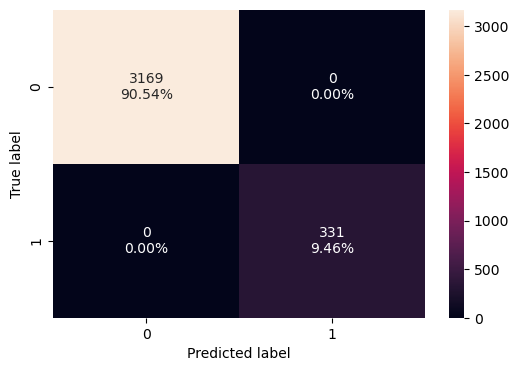

In [46]:
confusion_matrix_sklearn(model0, X_train, y_train)

#### Decision Tree Performance on Test Data

In [47]:
decision_tree_perf_train_without = model_performance_classification_sklearn(
    model0, X_train, y_train
)
decision_tree_perf_train_without

,Accuracy,Recall,Precision,F1
0,1.00000,1.00000,1.00000,1.00000


#### Confusion Matrix with Test Data

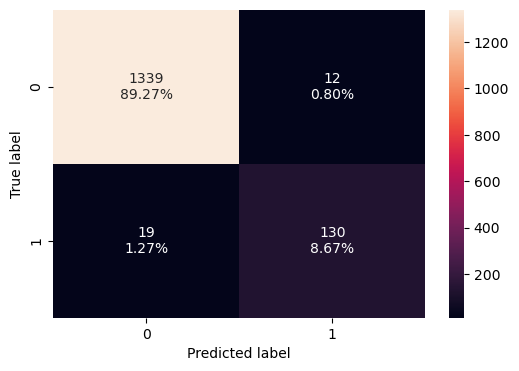

In [48]:
confusion_matrix_sklearn(model0, X_test, y_test)

#### Decision Tree Performance on Test Data

In [49]:
decision_tree_perf_test_without = model_performance_classification_sklearn(
    model0, X_test, y_test
)
decision_tree_perf_test_without

,Accuracy,Recall,Precision,F1
0,0.97933,0.87248,0.91549,0.89347


#### Summary
- Test Data Recall can be improved
- Test Data Recall and Training Data Recall are a little apart. Can be improved via Prepruning and Postpruning...

### Model Performance Improvement

#### PRE-PRUNING and Hypertuning

-  stop the tree-building process before it becomes too complex
- Do pre-pruning and tuning with hyperparameters:  ( max_depth, min_samples_leaf, max_leaf_nodes ) , class_weight, min_impurity_decrease
- Apply GridSearchCV with these parameters

In [50]:
# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    "class_weight": [None, "balanced"],
    "max_depth": np.arange(1, 10),
    "min_samples_leaf": [1,  3, 7, 10, 15, 20],
    "max_leaf_nodes": [ 2, 3, 5, 10],
    'min_impurity_decrease': [0.001,0.01,0.1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

estimator.fit(X_train, y_train) 

DecisionTreeClassifier(class_weight='balanced', max_depth=2, max_leaf_nodes=5,
                       min_impurity_decrease=0.001, random_state=1)

#### Pre-pruned Training Data Confusion Matrix

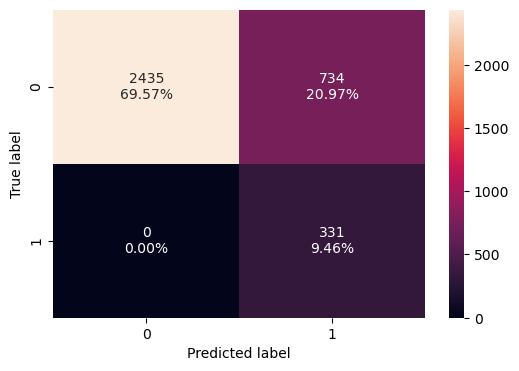

In [51]:
confusion_matrix_sklearn(estimator, X_train, y_train)

#### Pre-pruned Training Data Performance

In [52]:
decision_tree_tune_perf_train = model_performance_classification_sklearn(
    estimator, X_train, y_train
)
decision_tree_tune_perf_train

,Accuracy,Recall,Precision,F1
0,0.79029,1.00000,0.31080,0.47421


#### Pre-pruned TEST  Data Confusion Matrix

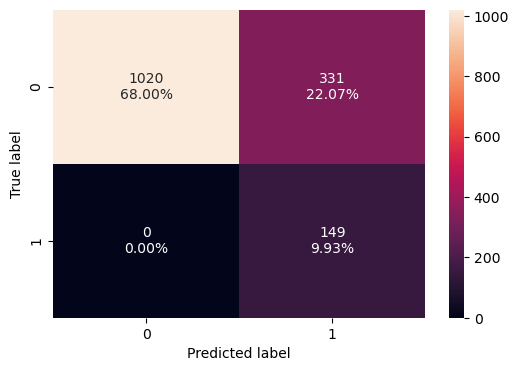

In [53]:
confusion_matrix_sklearn(estimator, X_test, y_test)

#### Pre-pruned TEST Data Performance

In [54]:
decision_tree_tune_perf_test = model_performance_classification_sklearn(
    estimator, X_test, y_test
)
decision_tree_tune_perf_test

,Accuracy,Recall,Precision,F1
0,0.77933,1.00000,0.31042,0.47377


#### PREPRUNING - Important features identified after Pre-pruning on training Data

In [55]:
feature_names = list(X_train.columns)
importances = estimator.feature_importances_
indices = np.argsort(importances)

#### PREPRUNING - Decision Tree Diagram

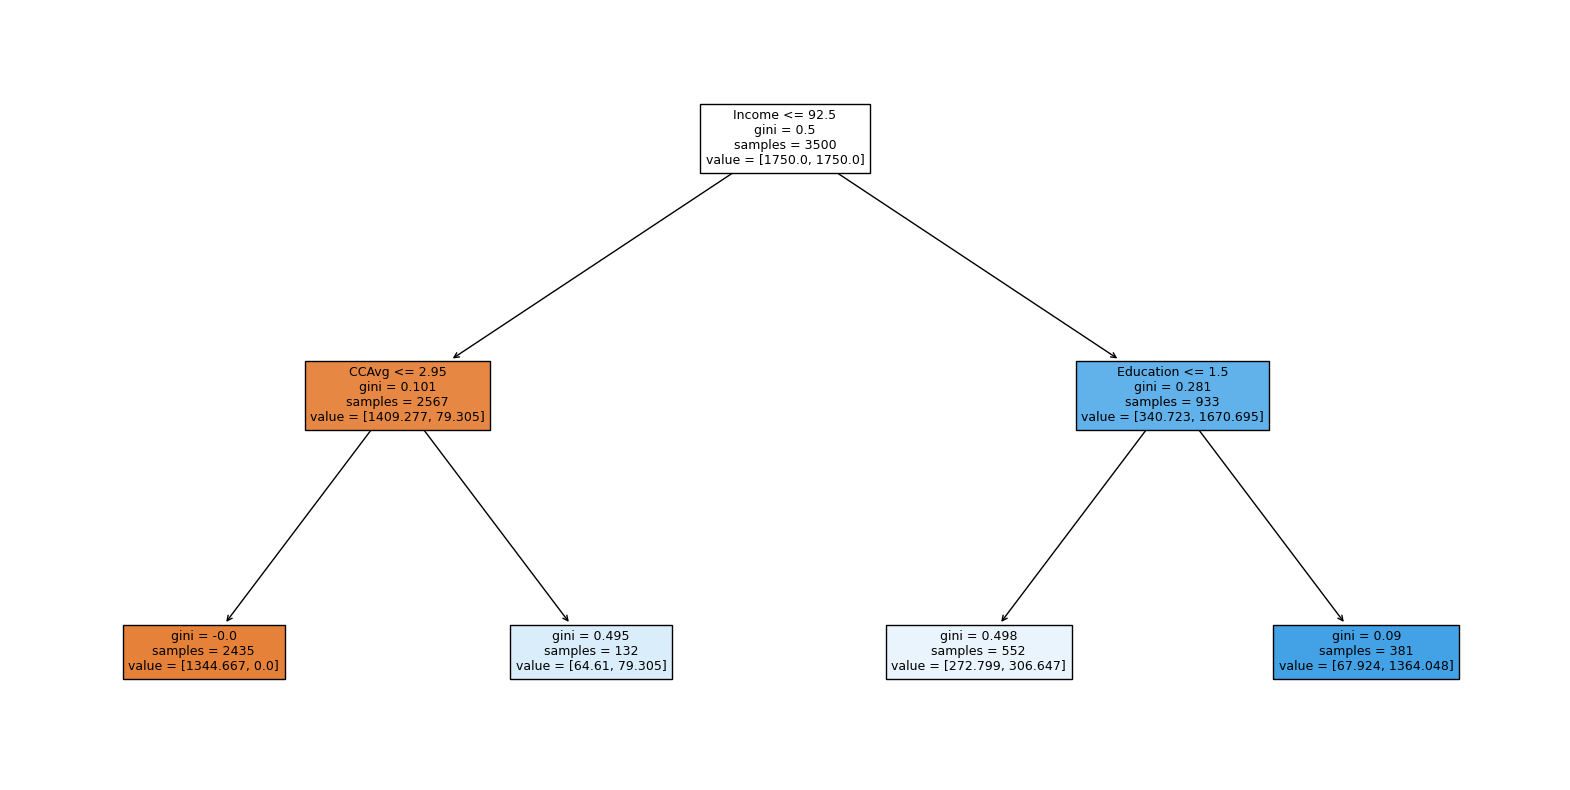

In [56]:
plt.figure(figsize=(20, 10))
out = tree.plot_tree(
    estimator,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()


#### PREPRUNING - Decision Tree in Textual Form

In [57]:
print(tree.export_text(estimator, feature_names=feature_names, show_weights=True))

|--- Income <= 92.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [1344.67, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- weights: [64.61, 79.31] class: 1
|--- Income >  92.50
|   |--- Education <= 1.50
|   |   |--- weights: [272.80, 306.65] class: 1
|   |--- Education >  1.50
|   |   |--- weights: [67.92, 1364.05] class: 1



In [58]:
#importances = estimator.feature_importances_
#importances

#### PREPRUNING - Important Features

In [59]:
# importance of features in the tree building
#importances = estimator.feature_importances_
#indices = np.argsort(importances)

#plt.figure(figsize=(8, 8))
#plt.title("Feature Importances")
#plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
#plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
#plt.xlabel("Relative Importance")
#plt.show()

In [60]:
print(
    pd.DataFrame(
        estimator.feature_importances_, columns=["IMPORTANCE"], index=X_train.columns
    ).sort_values(by="IMPORTANCE", ascending=False)
)

                         IMPORTANCE
Income                      0.82007
Education                   0.11730
CCAvg                       0.06263
Age                         0.00000
MajorCity_Redding           0.00000
...                             ...
MajorCity_Hayward           0.00000
MajorCity_Hermosa Beach     0.00000
MajorCity_Highland          0.00000
MajorCity_Hollister         0.00000
MajorCity_Yucaipa           0.00000

[254 rows x 1 columns]


#### Summary
- Recall improved but the rest of the scored degraded
- Recall in TEST and TRAIN data are same

#### POST-PRUNING - Cost Complexity Pruning

- Calculate the effective alphas and their corresponding impurities.  ccp_alphas / effective alphas are  trade-off between  complexity and  misclassification rate.
- Used Balanced class weights

In [61]:
# ccp_alphas / effective alphas are  trade-off between  complexity and  misclassification rate.
clf = DecisionTreeClassifier(random_state=1, class_weight="balanced")
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = abs(path.ccp_alphas), path.impurities



In [62]:
pd.DataFrame(path)

,ccp_alphas,impurities
0,0.00000,-0.00000
1,0.00000,-0.00000
2,0.00000,-0.00000
3,0.00000,-0.00000
4,0.00016,0.00031
5,0.00016,0.00063
6,0.00016,0.00094
7,0.00028,0.00205
8,0.00028,0.00510
9,0.00029,0.00567


#### POSTPRUNING- Plot of Total Impurity v/s Effective Alpha

- Check at what alpha the impurities are minimum

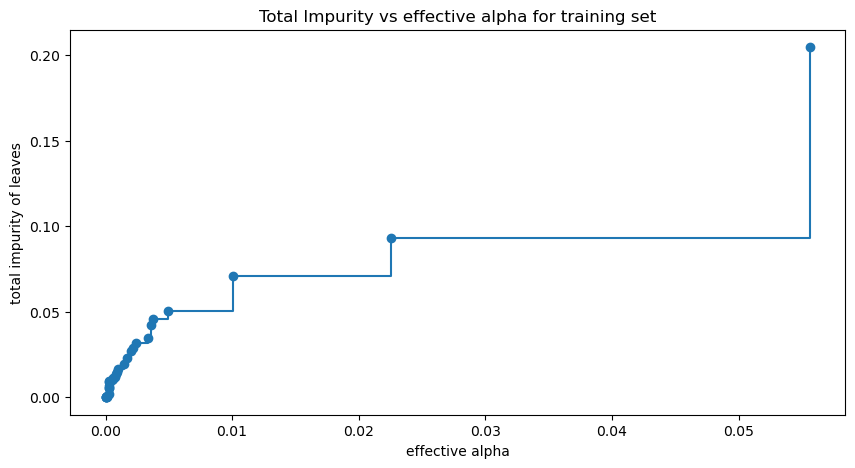

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

#### POSTPRUNING- Iterate through different effective alpha values and train different decision trees using these alpha values.

In [64]:
# iterate through different effective alpha values and trains decision trees using these alpha values.


clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=1, ccp_alpha=ccp_alpha, class_weight="balanced"
    )
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
    # Last alpha value prunes whole tree , leaving only 1 node
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.2953792759992322


#### POSTPRUNING-Plot the node counts and depths of all the above decision trees against the alpha values, to find out what the optimum low node count and depth for a low alpha, such that the decision tree is not overfitted.

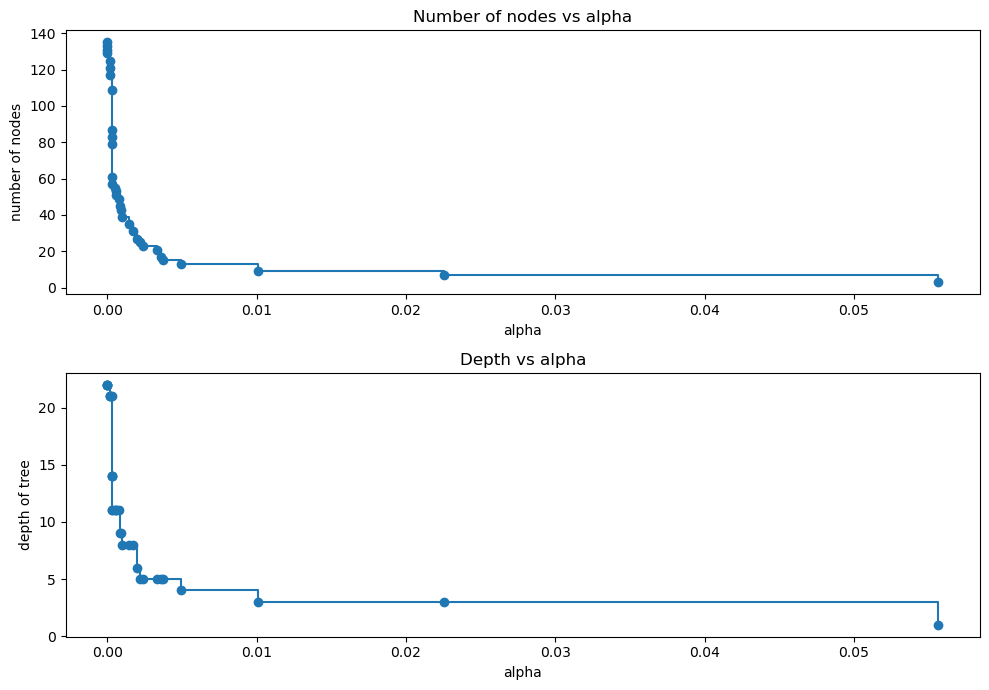

In [65]:
# Plot the node counts and depths of all the above trees against the alpha values.
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

#### POSTPRUNING- Calculate recall scores for all the above trees WITH TRAINING & TEST DATA


In [66]:
# Calculate recall scores for all the above trees WITH TRAINING DATA

recall_train = []
for clf in clfs:
    pred_train = clf.predict(X_train)
    values_train = recall_score(y_train, pred_train)
    recall_train.append(values_train)

In [67]:
# Calculate recall scores for all the above trees WITH TEST DATA

recall_test = []
for clf in clfs:
    pred_test = clf.predict(X_test)
    values_test = recall_score(y_test, pred_test)
    recall_test.append(values_test)

#### POSTPRUNING- Analyze  trade-off between  complexity and recall

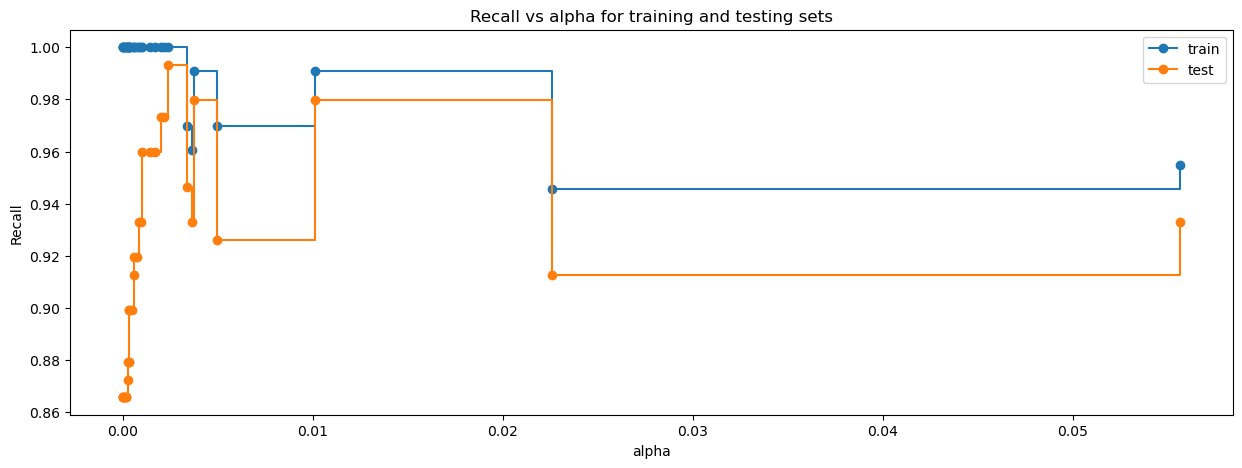

In [68]:
# analyze  trade-off between  complexity and recall

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(
    ccp_alphas, recall_train, marker="o", label="train", drawstyle="steps-post",
)
ax.plot(ccp_alphas, recall_test, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

#### POSTPRUNING- Choose the model with the highest TEST RECALL

In [69]:
# creating the model where we get highest test recall
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.002375808619774645, class_weight='balanced',
                       random_state=1)


#### POSTPRUNING - TRAINING & TEST DATA - CONFUSION MATRIX & PERFORMANCE

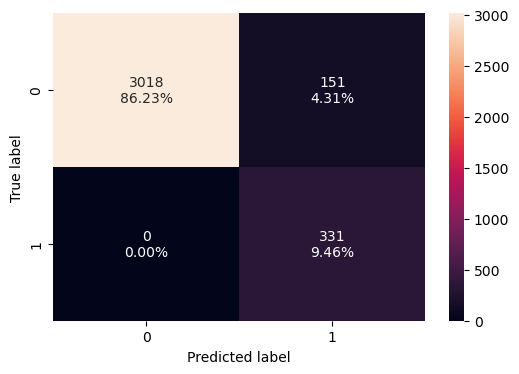

In [70]:
confusion_matrix_sklearn(best_model, X_train, y_train)

In [71]:
decision_tree_post_perf_train = model_performance_classification_sklearn(
    best_model, X_train, y_train
)
decision_tree_post_perf_train

,Accuracy,Recall,Precision,F1
0,0.95686,1.00000,0.68672,0.81427


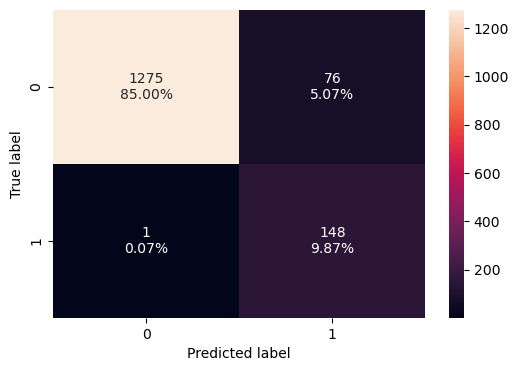

In [72]:
confusion_matrix_sklearn(best_model, X_test, y_test)

In [73]:
decision_tree_post_test = model_performance_classification_sklearn(
    best_model, X_test, y_test
)
decision_tree_post_test

,Accuracy,Recall,Precision,F1
0,0.94867,0.99329,0.66071,0.79357


#### POSTPRUNING - FINAL CHOSEN BEST MODEL - IMPORTANT FEATURES

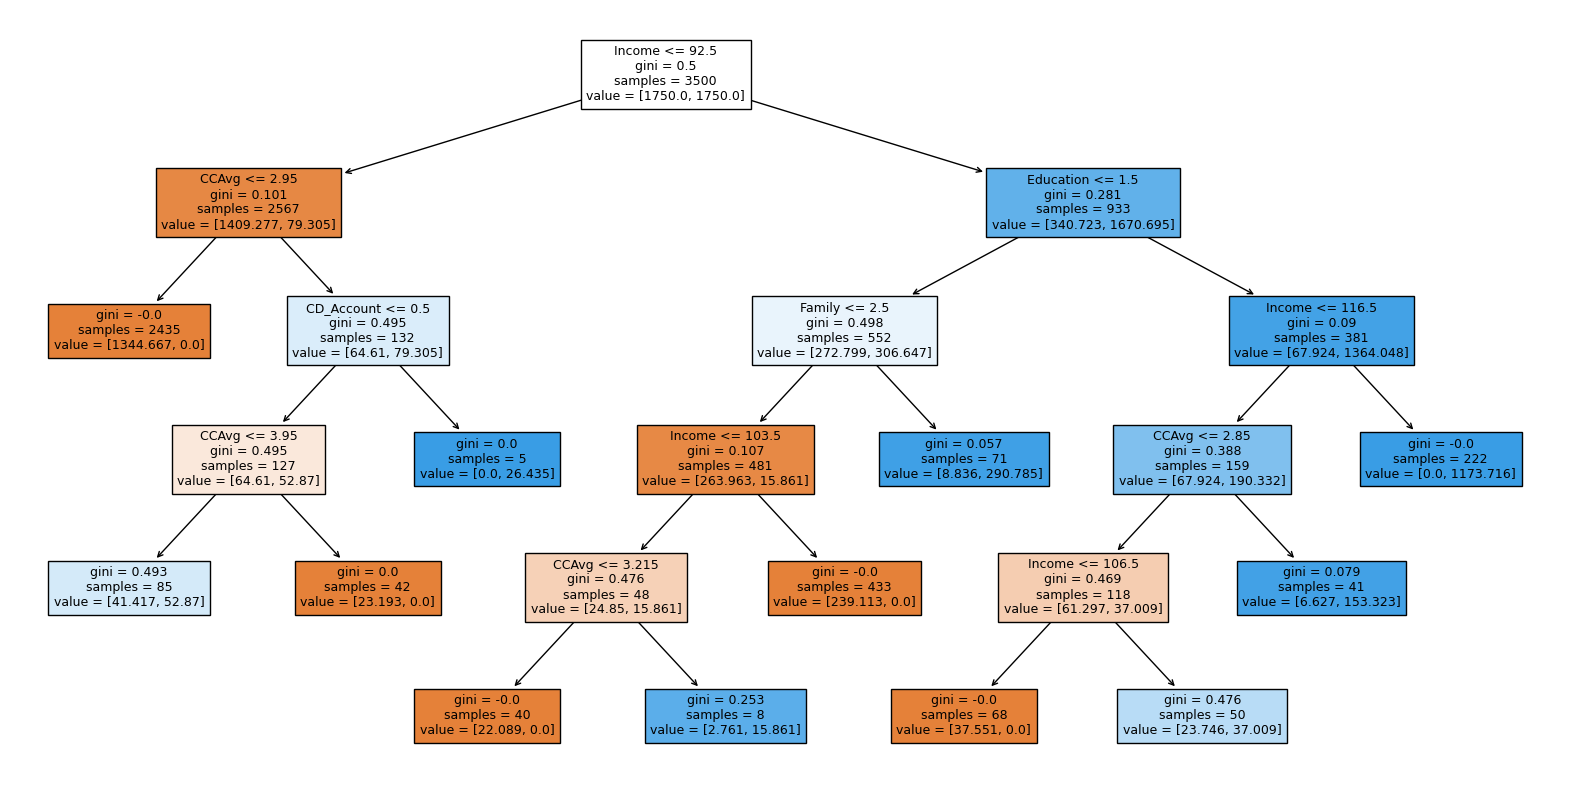

In [74]:
plt.figure(figsize=(20, 10))

out = tree.plot_tree(
    best_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

#### POSTPRUNING - IMPORTANT FEATURES IN THE FINAL CHOSEN BEST MODEL

In [75]:
# Check the depth of the pruned tree
pruned_tree_depth = best_model.tree_.max_depth
print("Depth of the pruned tree:", pruned_tree_depth)

Depth of the pruned tree: 5


In [76]:
importances = best_model.feature_importances_
indices = np.argsort(importances)

In [77]:
#plt.figure(figsize=(12, 12))
#plt.title("Feature Importances")
#plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
#plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
#plt.xlabel("Relative Importance")
#plt.show()

In [78]:
print(
    pd.DataFrame(
        best_model.feature_importances_, columns=["IMPORTANCE"], index=X_train.columns
    ).sort_values(by="IMPORTANCE", ascending=False)
)

                            IMPORTANCE
Income                         0.66515
Family                         0.14735
Education                      0.09016
CCAvg                          0.08937
CD_Account                     0.00796
...                                ...
MajorCity_Highland             0.00000
MajorCity_Hollister            0.00000
MajorCity_Hopland              0.00000
MajorCity_Huntington Beach     0.00000
MajorCity_Yucaipa              0.00000

[254 rows x 1 columns]


## Model Comparison and Final Model Selection

#### Training DATA performance comparison


In [79]:
# training performance comparison

models_train_comp_df = pd.concat(
    [

        decision_tree_tune_perf_train.T,
        decision_tree_post_perf_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [

    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree (Pre-Pruning),Decision Tree (Post-Pruning)
Accuracy,0.79029,0.95686
Recall,1.00000,1.00000
Precision,0.31080,0.68672
F1,0.47421,0.81427


#### TEST DATA performance comparison

In [80]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [
        decision_tree_tune_perf_test.T,
        decision_tree_post_test.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Post-Pruning)",
]
print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


,Decision Tree (Pre-Pruning),Decision Tree (Post-Pruning)
Accuracy,0.77933,0.94867
Recall,1.00000,0.99329
Precision,0.31042,0.66071
F1,0.47377,0.79357


In [81]:
# we predicted probabilities for the positive class , class 1, ie [:,1]
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score:", auc_roc)
gini_coefficient = 2 * auc_roc - 1
print("Gini Coefficient:", gini_coefficient)


AUC-ROC Score: 0.9901663694305486
Gini Coefficient: 0.9803327388610972


#### Overview

- Our original 1st Decision Tree had Recalls for Test Data v/s Training Data a little apart, and neither were close to 1.
- PREPRUNING improved the above Recall in TEST DATA to 1, while other scores had worsened
- POSTPRUNING improved all other scores on TEST DATA while maintaining TEST data recall  still almost 1. AUC-ROC score is also high.
- Depth of the postpruned tree = 5

Summary: Postpruned Decision Tree above is the best one.

## Actionable Insights and Business Recommendations


* What recommedations would you suggest to the bank?

Target customers that fall in the below categories:

#### From EDA:
From the bivariate analyses : Following group of liability customers  are more likely take a new loan:
- People with median 3 family members, median CCavg 3.70, no personal loan, income > 135k, education >=2 
- Customers who have 'CCAvg' >= 3.75 & No 'Personal_Loan' & 'Income' >= 137.5 : there are 192 such customers who are 50% likely to take a personal loan. These 192 customers are  in increasing order likely in LA, San Diego, Santa Barbara, SanFrancisco/Livermore
- Personal loans are taken by people with education 2: Graduate and 3: Advanced/Professional
- Personal loans are taken by people with median 3 family members and 75% of people having 4 family members and below
- Personal loans are taken by people with more income (median around 140 per month) and  75% are in the range of 160-170 and below.
- Personal loans are taken by 75% of people having CCavg that is slightly > 5 (median 3.75) and below.


#### From DECISION TREE ML MODEL:
- The top 4 features in terms of relative importance are: Income(66.5%), Family (14.7%), Education (9%), CCAvg (8.9%)
- The Bank can follow the decision tree inorder to target customers. Below  are  a good group to target (in no particular order):
1) Income <= 92.5 ; CCAvg <= 2.95 
2) Incomes > 92.5; Education > 1.5; Income > 116.5; 
3) Other paths to leaf nodes that have low gini impurity value. There are several  combination of nodes/independent variables which result in a low Gini impurity score that result in a leaf having low or 0 gini impurity score. These nodes / conditions could be utilised by the bank, to arrive at the set of liability customers to target for Personal_Loan.





#### Generate HTML for submission

In [83]:
!jupyter nbconvert --to html "C:\\Users\\abrah\\Downloads\\PGAIML\proj2\\Abraham_SL_Full_Code.ipynb"

[NbConvertApp] Converting notebook C:\\Users\\abrah\\Downloads\\PGAIML\proj2\\Abraham_SL_Full_Code.ipynb to html
[NbConvertApp] Writing 3852686 bytes to C:\Users\abrah\Downloads\PGAIML\proj2\Abraham_SL_Full_Code.html


___